<a href="https://colab.research.google.com/github/manu675/Data_Mining_Cup_Prudsys_21/blob/master/final_combined_recommender_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports / Data


In [ ]:
!pip install nltk
!pip install unidecode

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from unidecode import unidecode
nltk.download('punkt')
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors
import random
import math
np.random.seed(1) #setting random seed for reproducibility


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pfad = "drive/MyDrive/DataMiningSeminar/"
items_df = pd.read_csv(pfad + "items.csv", delimiter='|')
items_df['itemID'] = items_df.itemID.astype(str)
items_df['author'] = items_df.author.astype(str)
items_df['main topic'] = items_df['main topic'].astype(str)

trans_df = pd.read_csv(pfad + "transactions.csv", delimiter='|')
trans_df['itemID'] = trans_df.itemID.astype(str)
trans_df['sessionID'] = trans_df.sessionID.astype(str)

eval_df = pd.read_csv(pfad + "evaluation.csv", delimiter='|')
eval_df['itemID'] = eval_df.itemID.astype(str)

descriptions_df = pd.read_csv(pfad + "Description_Cover_Data.csv", encoding="ISO-8859-1")
descriptions_df = descriptions_df[['itemID','desc']]
descriptions_df['itemID'] = descriptions_df['itemID'].astype(str)

items_df = items_df.merge(descriptions_df, 'left', on='itemID')
items_df.desc = items_df.desc.astype(str)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

## items_df

In [ ]:
## This row seems problematic, isn't it? ID 62676 is from Beatrice Harrison. We can remove this row cuz we do not have it in evaluation data.
#Comment by Frederic: I would keep it, as it could be a recommendation for another book. I'd suggest we just change the main topic to YXE here.
items_df = items_df[~(items_df['main topic'] == "[5PGM,YXE]")]

In [ ]:
#Is this still needed?
items_list = list(items_df.itemID.unique())
topic_list = list(items_df['main topic'].unique())

In [ ]:
## Items which do not have main topic but included in evaluation data. I suggest to replace NA values with subtopics. How do you think about it?
items_df[(items_df['itemID'].isin(eval_df.itemID)) & (items_df['main topic'].isna())]

,itemID,title,author,publisher,main topic,subtopics,desc


In [ ]:
## Hard coding for rows which do not have main topic.
items_df.loc[items_df['itemID']=="6798", 'main topic'] = "FM"
items_df.loc[items_df['itemID']=="23417", 'main topic'] = "FMR"
items_df.loc[items_df['itemID']=="58820", 'main topic'] = "FLS"
items_df.loc[items_df['itemID']=="69755", 'main topic'] = "5AQ"

In [ ]:
items_df = items_df[~items_df["main topic"].isna()]

In [ ]:
#set itemID as index column of eval and item dfs
eval_df = eval_df.set_index("itemID")
items_df = items_df.set_index("itemID")

In [ ]:
# import
from unidecode import unidecode

In [ ]:
# hardcoding the Umlauts and ß characters
items_df["title_cleaned"] = items_df.title.apply(lambda x: x.replace("ä","ae"))
items_df["title_cleaned"] = items_df.title_cleaned.apply(lambda x: x.replace("ö","oe"))
items_df["title_cleaned"] = items_df.title_cleaned.apply(lambda x: x.replace("ü","ue"))
items_df["title_cleaned"] = items_df.title_cleaned.apply(lambda x: x.replace("ß","ss"))


In [ ]:
# cleaning the titles

# Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def getunicode(text): # (to preserve ÜÄÖ characters, they have to to be hardcoded as ae, oe, ue )
    return unidecode(text)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words(["english","german"]))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

items_df['title_cleaned'] = items_df['title'].apply(getunicode) # creating a new cleaned title column
items_df['title_cleaned'] = items_df.title_cleaned.apply(func = make_lower_case)
items_df['title_cleaned'] = items_df.title_cleaned.apply(func = remove_stop_words)
items_df['title_cleaned'] = items_df.title_cleaned.apply(func=remove_punctuation)

## Trans_df

In [ ]:
# Create column based on number of items in session
trans_df['session_count'] = trans_df.groupby('sessionID')['itemID'].transform('count')
trans_df['item_count'] = trans_df.groupby('itemID')['sessionID'].transform('count')

#Filter by session_count>=2 to include sessions with more than 1 items.
sig_trans_df = trans_df[trans_df['session_count']>1]

# Regard click, basket, order values to boolean values.
sig_trans_df.loc[sig_trans_df["click"]>=1, "click"] = 1
sig_trans_df.loc[sig_trans_df["basket"]>=1, "basket"] = 1
sig_trans_df.loc[sig_trans_df["order"]>=1, "order"] = 1

del sig_trans_df['session_count']
del trans_df['session_count']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
sig_trans_df.head()

,sessionID,itemID,click,basket,order,item_count
7,7,14576,1,1,0,31
8,7,17731,1,1,0,18
13,12,30277,1,0,0,6
14,12,29508,1,1,0,8
15,12,75659,1,0,0,4


In [ ]:
(sig_trans_df.shape, trans_df.shape)

((129501, 6), (365143, 6))

In [ ]:
trans_df

,sessionID,itemID,click,basket,order,item_count
0,0,21310,1,0,0,3
1,1,73018,1,0,0,59
2,2,19194,1,0,0,186
3,3,40250,1,0,0,339
4,4,46107,1,0,0,25
...,...,...,...,...,...,...
365138,279351,70183,1,0,0,174
365139,279352,39716,1,0,0,767
365140,279353,35260,1,0,0,22
365141,279353,18805,4,0,0,133


# Author Module

In [ ]:
with open("drive/MyDrive/DataMiningSeminar/character_cleaning_dict.pkl", "rb") as f:
    letter_dict = pickle.load(f)

In [ ]:
letter_dict

{' ': ' ',
 '!': ' ',
 '"': ' ',
 '$': ' ',
 '&': ',',
 "'": ' ',
 '(': ' ',
 ')': ' ',
 '*': ' ',
 '+': ' ',
 ',': ',',
 '-': ' ',
 '.': ' ',
 '/': ' ',
 '0': '0',
 '1': '1',
 '2': '2',
 '4': '4',
 '5': '5',
 '6': '6',
 '7': '7',
 '8': '8',
 ':': ' ',
 '?': ' ',
 '_': ' ',
 '`': ' ',
 'x': 'x',
 '\x8e': ' ',
 '\xa0': ' ',
 '©': ' ',
 '¬': ' ',
 '°': ' ',
 '³': ' ',
 '¶': ' ',
 'ß': 'ss',
 'à': 'a',
 'á': 'a',
 'â': 'a',
 'ã': 'a',
 'ä': 'ae',
 'å': 'a',
 'æ': 'ae',
 'ç': 'c',
 'è': 'e',
 'é': 'e',
 'ê': 'e',
 'ë': 'e',
 'ì': 'i',
 'í': 'i',
 'î': 'i',
 'ï': 'i',
 'ñ': 'n',
 'ò': 'o',
 'ó': 'o',
 'ô': 'o',
 'ö': 'oe',
 'ø': 'o',
 'ù': 'u',
 'ú': 'u',
 'û': 'u',
 'ü': 'ue',
 'ý': 'y',
 'ÿ': 'y'}

In [ ]:
def clean_string(string, dictionary):
    string = string.lower()
    for letter in dictionary:
        string = string.replace(letter, dictionary[letter])
    return string.strip()

In [ ]:
items_df["authors_list"] = items_df["author"].map(lambda x: x.split(","))
items_df["authors_list"] = items_df["authors_list"].map(lambda x: [clean_string(author, letter_dict) for author in x if author != [] and author != "nan"])

all_authors_list = items_df["authors_list"].tolist()
list_of_unique_authors = list(set([author for sublist in all_authors_list for author in sublist]))
list_of_unique_authors.sort()

In [ ]:
def get_author_recommendations(eval_itemID="21310", df=items_df, num=5):
    eval_authors = df.loc[eval_itemID, "authors_list"]
    df = df.loc[df.index != eval_itemID]
    df["score"] = df["authors_list"].map(lambda x: len(set(x).intersection(set(eval_authors)))/(len(x)+len(eval_authors)-1) if len(x)>0 and len(eval_authors)>0 else 0)
    
    result_df = df.loc[(df["score"] > 0) & (df["score"] == df["score"].max())]

    while len(result_df) < num:
        previous_len = len(result_df)
        df = df.loc[~df.index.isin(result_df.index)]
        result_df = result_df.append(df.loc[(df["score"] > 0) & (df["score"] == df["score"].max())])
        if previous_len >= len(result_df):
            break

    return result_df

# Language Qualifiers

In [ ]:
items_df["subtopics"] = items_df["subtopics"].map(lambda x: x.replace("[","").replace("]","").split(","))
items_df["subtopics"] = items_df["subtopics"].map(lambda x: [topic.strip() for topic in x])

In [ ]:
items_df["language_qualifier"] = items_df["subtopics"].map(lambda x: [topic for topic in x if len(topic)>0 and topic[0]=="2" ])
items_df["language_qualifier"] = items_df["language_qualifier"].map(lambda x: x[0] if x!=[] else "nan")

In [ ]:
language_dict = {"2ACG": "de",
                 "2ACB": "en",
                 "2ACBK": "en",
                 "2ADF": "fr",
                 "2ADL": "la",
                 "2A" : "nan",
                 "2AGR": "ru",
                 "2ACSX": "nan",
                 "2AGP": "pl",
                 "2GJ": "ja",
                 "2ZM": "nan",
                 "2AJBL": "lt",
                 "2ADS": "es",
                 "2ACZ": "nan", 
                 "2AC": "de",
                 "2BMH": "hi",
                 "2AFS": "en",
                 "2ACGM": "de",
                 "2ADT": "it",
                 "2GDC": "zh",
                 "2CSJ": "nan",
                 "nan" : "nan"
                 }

In [ ]:
items_df = items_df.replace({"language_qualifier": language_dict})

# Language Detection (Manuel)

In [ ]:
# language detection library
%pip install fasttext

In [ ]:
import fasttext

In [ ]:
# downloading the model
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2021-06-28 21:50:10--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  12.6MB/s    in 11s     

2021-06-28 21:50:22 (11.3 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



In [ ]:
# loading the model
PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

handling the \n problem in the raw titles

In [ ]:
items_df["title"] = items_df.title.apply(lambda x: x.replace("\n"," "))
items_df["desc"] = items_df.desc.apply(lambda x:  x if x == "nan" else x.replace("\n"," "))

predicting the language for the title feature

In [ ]:
items_df["language_title"] = items_df.title.apply(lambda x: model.predict(x)[0][0]) # removing 1 element tuple
items_df["score_language_title"] = items_df.title.apply(lambda x: model.predict(x)[1][0]) # removing the 1 element list
items_df["language_desc"] = items_df.desc.apply(lambda x: model.predict(x)[0][0] if x != "nan" else x ) # removing 1 element tuple
items_df["score_language_desc"] = items_df.desc.apply(lambda x: model.predict(x)[1][0] if x != "nan" else 0) # removing the 1 element list

In [ ]:
# renaming the values in the language column
items_df["language_title"] = items_df.language_title.apply(lambda x: x.replace("__label__",""))
items_df["language_desc"] = items_df.language_desc.apply(lambda x: x.replace("__label__",""))

In [ ]:
items_df["language"] = np.select([items_df.language_qualifier != "nan" , items_df.score_language_title >= 0.3], [items_df.language_qualifier, items_df.language_title], default=items_df.language_desc)
temp_df = pd.merge(items_df, eval_df, on = "itemID")
language_hardcoding = pd.read_excel(pfad + "language_hardcoding.xlsx")
language_hardcoding.language = language_hardcoding.language.astype("str")
# list of eval ids, which has "nan" as language (21 items)
eval_ids = temp_df[temp_df.language == "nan"].index.to_list()
language_nan = language_hardcoding.loc[language_hardcoding.itemID.isin(eval_ids), "language"].to_list()
items_df.loc[items_df.index.isin(eval_ids), "language"]= language_nan
#items_df[items_df.index.isin(eval_ids)].language = language_hardcoding[language_hardcoding.itemID.isin(eval_ids)].language


In [ ]:
items_df.language.value_counts()

en     50259
de     18578
es      3189
nan     1487
it      1176
       ...  
ur         1
rm         1
sco        1
kv         1
kn         1
Name: language, Length: 79, dtype: int64

In [ ]:
items_df.loc[items_df["language"] == "zh"]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language
itemID,,,,,,,,,,,,,,
24491,Kapsel,"Anna Wu, Baoshu, Anja Kümmel, Tim Holland",Fruehwerk Verlag,FL,"[1FPC, 2GDC]",nan,kapsel,"[anna wu, baoshu, anja kuemmel, tim holland]",zh,de,0.690687,nan,0.000000,zh
64424,Spiegel,Cixin Liu,Heyne Taschenbuch,FLP,"[1FPC, 2GDC, FLP, FYB, FYT, PHQ]",nan,spiegel,[cixin liu],zh,de,0.449791,nan,0.000000,zh
481,NECROSTEAM,nan,p.machinery,FLM,[],nan,necrosteam,[],nan,zh,0.317938,nan,0.000000,zh
86,KILL,Eve Silver,FISCHER FJB,FL,"[FRD, FYT]",nan,kill,[eve silver],nan,zh,0.348721,nan,0.000000,zh
20168,'SIKARAN SHIELD LORD',Reverend Joanna Z. Ray,Lulu.com,FL,[],nan,sikaran shield lord,[reverend joanna z ray],nan,zh,0.301633,nan,0.000000,zh
66352,TSUKIMONOGATARI,Nisioisin,Random House LCC US,FYV,"[FB, FMW]",Koyomi Araragi is studying hard in preparation...,tsukimonogatari,[nisioisin],nan,zh,0.414413,en,0.971789,zh
44210,Xeeh,Klaus Seibel,Books on Demand,FL,[],Xeeh ist das Vorgehen von Anne Winkler zu harm...,xeeh,[klaus seibel],nan,zh,0.393043,de,0.996193,zh
38529,BEX,Tomke Jantzen,Books on Demand,FMK,"[FMK, FMX, FRX]","""Superhelden werden vÃ¶llig Ã¼berbewertet!"" Un...",bex,[tomke jantzen],nan,zh,0.363067,de,0.994551,zh
9834,Krafttier,Larry P. Guerriera,Verlagshaus Schlosser,FBC,[FM],nan,krafttier,[larry p guerriera],nan,zh,0.342919,nan,0.000000,zh


# Jee

In [ ]:
## This function calculate similarity with pyramid distance. And we added some weight for the position of letters.
def get_pyramid_similarity(str1, str2):
    '''
    Arguments:
    str1: string
    str2: string
    Returns:
    similarity: "Pyramid" similarity between str1 and str2
    '''
    dist = 0
    for i in range(min(len(str1), len(str2))):
        if dist == 0:
            if str1[i] != str2[i]:
                dist += 2/(2**i)
        else:
            if str1[i-1] == str2[i-1]:
                if str1[i] != str2[i]:
                    dist += 2/(2**i)
            else:
                dist += 2/(2**i)

    if len(str1) != len(str2):
        for j in range(min(len(str1),len(str2)), max(len(str1),len(str2))):
            dist += 1/(2**j)
            
    similarity = round(1/(dist+1),2)
    if similarity <= 0.33:
        similarity = 0

    return similarity

In [ ]:
## Create candidate dictionary
def get_trans_dict(df=sig_trans_df):       #weights=[1,2,3]): This is for mixed score.
    '''
    Arguments:
    df: Which transaction data will we use.
    N: Number of candidates we want.
    Returns:
    candidates: Dictionary for candidates.
    scores: Dictionary for score of candidates
    '''
    eval_included_sessions = df[df['itemID'].isin(eval_df.index)]['sessionID']
    eval_included_trans_df = df[df['sessionID'].isin(eval_included_sessions)]
    items = eval_df[eval_df.index.isin(df['itemID'])].index.to_list()
    candidates= {}

    for i in items:
        item_included_sessions = eval_included_trans_df[eval_included_trans_df['itemID']==i]['sessionID'] # Sessions which items are in.
        included_df = df[df['sessionID'].isin(item_included_sessions)] # Filtering dataframe by session
        # Instead of item_count, we can also use sum of other columns, such as orders or clicks.
        # We are gonna use item cooccurence and confidence score instead of 
        item_cooccurence = included_df[included_df['itemID']!= i].groupby('itemID').count()['click']
        # item_click = included_df[included_df['itemID']!= i].groupby('itemID').sum()['click']
        # item_basket = included_df[included_df['itemID']!= i].groupby('itemID').sum()['basket']
        # item_order = included_df[included_df['itemID']!= i].groupby('itemID').sum()['order']
        # score = weights[0]*item_click+weights[1]*item_basket+weights[2]*item_order
        max_score = included_df[included_df['itemID']==i]['item_count'].mean()    #*sum(weights) This is for mixed score.
        score = item_cooccurence.sort_values(ascending=False)/max_score
        candidate = {}
        for j in score.index:
            candidate[j] = score[j]
        candidates[i] = candidate
    return candidates

In [ ]:
trans_dict = get_trans_dict(sig_trans_df)

In [ ]:
trans_dict

In [ ]:
def get_trans_candidates(evalID, trans_dict, candidates_list, threshold=0.1):
    '''
    Arguments:
    evalID: ID in evaluation data which we want to get recommendation
    candidates_dict: Candidates dictionary we got from get_trans_dict.
    scores_dict: Scores of candidates we got from get_trans_dict.
    threshold: Setting threshold of scores we want.
    N: Number of candidates we want.
    Returns:
    candidate_list: Final list of candidates based on transaction score.
    '''
    trans_candidates = trans_dict[evalID]
    filtered_candidates = []
    for k,v in trans_candidates.items():
        if k in candidates_list:
            if v > threshold:
                filtered_candidates.append(k)
    return filtered_candidates

## Work with similar authors

In [ ]:
author_trans = pd.merge(sig_trans_df, items_df["author"], how='left', left_on="itemID", right_index=True)
author_trans["author_session_count"] = author_trans.groupby(["author","sessionID"])["click"].transform("count") # Get the count per session
author_trans["author_session_count"] = 1/author_trans["author_session_count"] # Invert it to get the value from same session once
author_trans["author_count"] = author_trans.groupby("author")["author_session_count"].transform("sum") # Create new colum for author count
author_trans["author_count"]=author_trans["author_count"].astype(int) #Change to integer

In [ ]:
def get_similar_author(evalID, threshold=0.15):
  '''
  evalID: To get author of books with specific ID
  threshold: To get frequently bought together authors
  '''
  author = items_df.loc[evalID, "author"]
  author_included_sessions = author_trans[author_trans['author']==author]['sessionID'] # Sessions which items are in.
  author_included_df = author_trans[author_trans['sessionID'].isin(author_included_sessions)] # Filtering dataframe by session
  # author_cooccurence = author_included_df[author_included_df['author']!= author].groupby('author').count()['click'] # Get cooccurence with other authors
  author_cooccurence = author_included_df[author_included_df['author']!= author].groupby('author').sum()['author_session_count'] # This way can be better
  score = author_cooccurence/(author_trans[author_trans['author']==author]["author_count"].mean()) # Convert to confidence score
  score = score.sort_values(ascending=False) # Sort from top confidence values
  similar_authors = score[score>=threshold] # Get name of authors as list
  return similar_authors

In [ ]:
get_similar_author("12")

Series([], Name: author_session_count, dtype: float64)

## Topics base on transaction

In [ ]:
topic_trans = pd.merge(sig_trans_df, items_df["main topic"], how='left', left_on="itemID", right_index=True)
topic_trans["topic_session_count"] = topic_trans.groupby(["main topic","sessionID"])["click"].transform("count") # Get the count per session
topic_trans["topic_session_count"] = 1/topic_trans["topic_session_count"] # Invert it to get the value from same session once
topic_trans["topic_count"] = topic_trans.groupby("main topic")["topic_session_count"].transform("sum") # Create new colum for author count
topic_trans["topic_count"]=topic_trans["topic_count"].astype(int) #Change to integer

In [ ]:
def get_similar_topic(evalID, threshold=0.3):
  '''
  evalID: To get author of books with specific ID
  threshold: To get frequently bought together authors
  '''
  topic = items_df.loc[evalID, "main topic"]
  topic_included_sessions = topic_trans[topic_trans['main topic']==topic]['sessionID'] # Sessions which items are in.
  topic_included_df = topic_trans[topic_trans['sessionID'].isin(topic_included_sessions)] # Filtering dataframe by session
  # topic_cooccurence = topic_included_df[topic_included_df['main topic']!= topic].groupby('main topic').count()['click'] # Get cooccurence with other authors
  topic_cooccurence = topic_included_df[topic_included_df['main topic']!= topic].groupby('main topic').sum()['topic_session_count'] # This can be better
  score = topic_cooccurence/(topic_trans[topic_trans['main topic']==topic]["topic_count"].mean()) # Convert to confidence score
  score = score.sort_values(ascending=False) # Sort from top confidence values
  similar_topics = score[score>=threshold] # Get name of authors as list
  return similar_topics

In [ ]:
get_similar_topic("12")

main topic
FMB    0.367238
Name: topic_session_count, dtype: float64

# Transactions Module



## Trans DF Exploration

In [ ]:
trans_df

NameError: ignored

In [ ]:
trans_df.sort_values("click", ascending=False).head(10)

In [ ]:
#Assumption: Basket shouldn't happen without click, order shouldn't happen without basket
#Check how often Basket occurs without click
basket_no_order = trans_df.loc[(trans_df["click"]==0) & (trans_df["basket"]!=0)]
order_no_basket = trans_df.loc[(trans_df["basket"]==0) & (trans_df["order"]!=0)]

In [ ]:
print(f"{len(basket_no_order)/len(trans_df)*100:.2f}% of items were put in basket without click")
print(f"{len(order_no_basket)/len(trans_df)*100:.2f}% of items were ordered without being in basket")

In [ ]:
#For now, drop these rows
trans_df_clean = trans_df.loc[~trans_df.index.isin(basket_no_order.index) & ~trans_df.index.isin(order_no_basket.index)]
print(f"{(1-len(trans_df_clean)/len(trans_df))*100:.2f}% of rows were dropped")

In [ ]:
trans_df_clean.head(10)

In [ ]:
#Set order to 1 if the book has been ordered at least once
trans_df_clean["order_bool"] = trans_df_clean.loc[:,"order"].map(lambda x: 1 if x>=1 else 0)

In [ ]:
#Set basket to 1 if the book has been ordered at least once
trans_df_clean["basket_bool"] = trans_df_clean.loc[:,"basket"].map(lambda x: 1 if x>=1 else 0)

In [ ]:
trans_df_clean

In [ ]:
#How many different values are there for click
trans_df_clean["basket"].max()

In [ ]:
trans_df_clean.loc[(trans_df_clean["basket"] <= 10) & (trans_df_clean["basket"] > 0)]["basket"].hist(bins=10)

In [ ]:
trans_df_clean.loc[trans_df_clean["click"] <= 20]["click"].value_counts(bins=20).tolist()

In [ ]:
trans_df_clean.loc[(trans_df_clean["basket"] <= 10) & (trans_df_clean["basket"] > 0)]["basket"].hist(bins=10)

In [ ]:
trans_ordered = pd.merge(trans_df_clean.loc[trans_df_clean["basket"]>=1], items_df, how="inner", on="itemID")
trans_ordered

## Module Definition

In [ ]:
#Drop rows where there are orders but no baskets or where there are orders and no buckets
trans_df_clean = trans_df.loc[~trans_df.index.isin(basket_no_order.index) & ~trans_df.index.isin(order_no_basket.index)]
print(f"{(1-len(trans_df_clean)/len(trans_df))*100:.2f}% of rows were dropped")

6.47% of rows were dropped


In [ ]:
#Create Boolean variables for order and basket
trans_df_clean["order_bool"] = trans_df_clean.loc[:,"order"].map(lambda x: 1 if x>=1 else 0)
trans_df_clean["basket_bool"] = trans_df_clean.loc[:,"basket"].map(lambda x: 1 if x>=1 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Calculate p(order|basket) = p(basket,order)/p(basket)
p_basket_and_order = len(trans_df_clean.loc[(trans_df_clean["order_bool"]==1) & (trans_df_clean["basket_bool"]==1)])/len(trans_df_clean)
print(f"p(order,basket) = {p_basket_and_order*100:.2f}%")
p_basket = len(trans_df_clean.loc[trans_df_clean["basket_bool"]==1])/len(trans_df_clean)
print(f"p(basket) = {p_basket*100:.2f}%")

p(order,basket) = 1.08%
p(basket) = 9.88%


In [ ]:
p_order_given_basket = p_basket_and_order/p_basket
print(f"p(order|basket) = {p_order_given_basket*100:.2f}%")

p(order|basket) = 10.94%


In [ ]:
#Calculate p(basket|click=i) for all 1<=i<=n: p(basket|click=i)=p(basket, click)/p(click=i)
n=4
probs = []
for i in range(n):
  if i < n:
    p_basket_and_i = len(trans_df_clean.loc[(trans_df_clean["click"]==i+1) & (trans_df_clean["basket"]==1)])/len(trans_df_clean)
    p_i_times_clicked = len(trans_df_clean.loc[trans_df_clean["click"]==i+1])/len(trans_df_clean)
  else:
    p_basket_and_i = len(trans_df_clean.loc[(trans_df_clean["click"]>=i+1) & (trans_df_clean["basket"]==1)])/len(trans_df_clean)
    p_i_times_clicked = len(trans_df_clean.loc[trans_df_clean["click"]>=i+1])/len(trans_df_clean)
  
  p_basket_given_i = p_basket_and_i/p_i_times_clicked
  probs.append(p_basket_given_i)


In [ ]:
probs

[0.06978389079776298,
 0.2078494883015747,
 0.21832099176304184,
 0.23191401405539477]

In [ ]:
method = "Bayesian_Clicks"

if method == "Clicks":
  trans_df_clean.loc[:,"score"] = trans_df_clean["click"]

if method == "Boolean":
  trans_df_clean.loc[:,"score"] = trans_df_clean["order_bool"]
  trans_df_clean.loc[(trans_df_clean["score"]==0), "score"] = trans_df_clean["basket_bool"]
  trans_df_clean.loc[(trans_df_clean["score"]==0), "score"] = trans_df_clean["click_bool"]


if method == "Linear_Weighting":
  trans_df_clean.loc[:,"score"] = trans_df_clean["order_bool"]*3
  trans_df_clean.loc[(trans_df_clean["score"]==0), "score"] = trans_df_clean["basket_bool"]*2
  trans_df_clean.loc[(trans_df_clean["score"]==0), "score"] = trans_df_clean["click_bool"]*1


if method == "Bayesian_Clicks":
  trans_df_clean["score"]=0

  for i in range(n):
    if i < n:
      trans_df_clean.loc[(trans_df_clean["click"]==i+1), "score"] = probs[i]
    else:
      trans_df_clean.loc[(trans_df_clean["click"]>=i+1), "score"] = probs[i]

if method == "Bayesian":
  trans_df_clean.loc[:,"score"] = trans_df_clean["order_bool"]
  trans_df_clean.loc[trans_df_clean["score"]==0, "score"] = trans_df_clean["basket_bool"].map(lambda x: x*p_order_given_basket)

  for i in range(n):
    if i < n:
      trans_df_clean.loc[(trans_df_clean["score"]==0) & (trans_df_clean["click"]==i+1), "score"] = probs[i]*p_order_given_basket
    else:
      trans_df_clean.loc[(trans_df_clean["score"]==0) & (trans_df_clean["click"]>=i+1), "score"] = probs[i]*p_order_given_basket

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
trans_df_clean.head(10)

,sessionID,itemID,click,basket,order,item_count,order_bool,basket_bool,score
0,0,21310,1,0,0,3,0,0,0.069784
1,1,73018,1,0,0,59,0,0,0.069784
2,2,19194,1,0,0,186,0,0,0.069784
3,3,40250,1,0,0,339,0,0,0.069784
4,4,46107,1,0,0,25,0,0,0.069784
5,5,34217,1,0,0,93,0,0,0.069784
6,6,31436,1,0,0,28,0,0,0.069784
7,7,14576,1,1,0,31,0,1,0.069784
8,7,17731,2,1,0,18,0,1,0.207849
9,8,58723,1,0,0,12,0,0,0.069784


# Manuel/Linh

## KNN

Apply the kNN Model by topspinj: https://github.com/topspinj/recommender-tutorial/blob/master/part-1-item-item-recommender.ipynb

Find distance metrics here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric


In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df["sessionID"].nunique()
    M = df['itemID'].nunique()

    session_mapper = dict(zip(np.unique(df["sessionID"]), list(range(N))))
    item_mapper = dict(zip(np.unique(df["itemID"]), list(range(M))))
    
    session_inv_mapper = dict(zip(list(range(N)), np.unique(df["sessionID"])))
    item_inv_mapper = dict(zip(list(range(M)), np.unique(df["itemID"])))
    
    session_index = [session_mapper[i] for i in df["sessionID"]]
    item_index = [item_mapper[i] for i in df["itemID"]]

    X = csr_matrix((df["score"], (item_index, session_index)), shape=(M, N)) # bayesian score used as an input
    
    return X, session_mapper, item_mapper, session_inv_mapper, item_inv_mapper

In [ ]:
X, session_mapper, item_mapper, session_inv_mapper, item_inv_mapper = create_X(trans_df_clean)

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.01%


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
 def get_similar_items(item_ID, X, k, metric='cosine', show_distance=True):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations, choose from "cosine", "euclidean", "manhatten" etc.
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    item_ind = item_mapper[item_ID]
    item_vec = X[item_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)

    if isinstance(item_vec, (np.ndarray)):
        item_vec = item_vec.reshape(1,-1)
    distance, neighbour = kNN.kneighbors(item_vec, return_distance=show_distance)
    neighbour_dists = distance[0][1:]

    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(item_inv_mapper[n])
    neighbour_ids.pop(0)

    return neighbour_ids, neighbour_dists

**Conclusion:** For some books the recommendations are really good, e.g. itemID = "67832" or itemID = "73018", however there are some books where the recommendations are all over the plac, e.g. itemID = "21310" or "21264". 
In particular a hand full of books keeps showing up in these cases, e.g. "Death Asylum", "LEGO Harry Potter" and "Elian und Lira - Das wilde Herz"

We need to figure out why - a first step would be to look into scikit learn and try to get distance metrics from them, probably the distance is rather large for the bad recommendations but small for the good ones.

## Word2Vec

In [ ]:
# cleaning the titles

# Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _getunicode(text): # (to preserve ÜÄÖ characters, they have to to be hardcoded as ae, oe, ue )
    return unidecode(text)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

items_df['title_cleaned'] = items_df['title'].apply(_getunicode) # creating a new cleaned title column
items_df['title_cleaned'] = items_df.title_cleaned.apply(func = make_lower_case)
items_df['title_cleaned'] = items_df.title_cleaned.apply(func = remove_stop_words)
items_df['title_cleaned'] = items_df.title_cleaned.apply(func=remove_punctuation)

In [ ]:
# check
items_df["title_cleaned"].head()

itemID
21310                      princess poppy big mix
73018                  einfach zeichnen step step
19194                                 red queen 1
40250            meine kindergarten freunde pirat
46107    mein grosses schablonen buch wilde tiere
Name: title_cleaned, dtype: object

In [ ]:
# splitting the title into single words and storing them in a list
# in linguistics and NLP "corpus" refers to a collection of texts

corpus = []
for words in items_df['title_cleaned']:
    corpus.append(words.split())

In [ ]:
len(corpus) # length of the corpus list

78029

Google pretrained Word2Vec model

API of Word2Vec:  
https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Training our corpus using the Google Pretrained Model

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

--2021-06-28 21:50:56--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.76.158
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.76.158|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



(0, 0)

In [ ]:
# Creating a function called vectors for generating average Word2Vec embeddings 
# and storing them as a list called ‘word_embeddings’

# Generate the average word2vec for the each book description

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Add none rows to filter out one word titles.
    global none_rows
    none_rows = []

    # Reading the each book description 
    for line in items_df['title_cleaned']:
        avgword2vec = None
        count = 0
        
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)
        else: none_rows.append(line)

In [ ]:
vectors(corpus)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
items_df[items_df["title_cleaned"]=='manitou']

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language
itemID,,,,,,,,,,,,,,
63067,Manitou,Johnny van Neerven,Austin Macauley,FM,[],Johnny Moran's life is transformed from rags-t...,manitou,[johnny van neerven],nan,en,0.429559,en,0.971609,en


In [ ]:
none_rows

['mats milad',
 'metabolic',
 '144000',
 'gamechanger',
 'spinnenkuss',
 'starsight',
 'kernstaub',
 'loveless',
 'vorstadtprinzessin',
 'canticle leibowitz',
 'gepardensommer',
 'kodexfieber',
 'viggo',
 'hogfather',
 'compelled',
 'poeti shqiptar',
 'spinnengift',
 'spinnenblitz',
 'spinnenrache',
 'geisterwald knochenklippen',
 'koalatraume',
 'schneeriese',
 'honigkuckuckskinder',
 'elfenranke',
 '2312',
 'weltendunkel',
 'erhebung',
 'taviano',
 'soulstar',
 'munchhausen',
 'spinnenzeit',
 'pina bausch',
 'mudshark',
 'ausgewechselt',
 'muncle trogg',
 'saeculum',
 'zeitflut',
 'offshore',
 'exploit',
 'eleatan',
 'zwillingskronen',
 'mondsilberzauber',
 'competence',
 'spinnenherz',
 'alphawolfin',
 'engelslust',
 'kakaoherz listenliebe',
 'abyssum',
 'planetenjager',
 'indigosommer',
 'spinnenwinter',
 '381',
 'junkgirl',
 'forced perspectives',
 'traumtreffer',
 'shadowbreaker',
 'rabengelachter',
 'graswelt',
 'sternenkinder',
 'wolfshybride',
 'engelszwillinge',
 'seelendrach

In [ ]:
#Filter out one word titles and reset index.
items_filtered = items_df[~(items_df['title_cleaned'].isin(none_rows))]
items_filtered.reset_index(inplace=True, drop=True)

In [ ]:
array_embeddings = word_embeddings

len(word_embeddings)

73951

In [ ]:
# Recommending the Top 5 similar books using Average Word2Vec

def title_recommendations(title, df, array_embeddings, threshold=0.75):

    # Calling the function vectors

    # vectors(items_df)
    
    # # finding the cosine similarity for the vectors (cosine_similarity tries to run the sparse dot product)
    # if title in none_rows:
    #   ##df_combined.set_index('title', inplace = True) # modifying the dataframe in place (not in a new object)

    #   # Create a TF-IDF matrix (containing the TFIDF scores) of unigrams, bigrams, and trigrams for each book title
    #   tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english')
    #   none_df = items_df[items_df['title_cleaned'].isin(none_rows)].reset_index()
    #   tfidf_matrix = tf.fit_transform(none_df['title_cleaned']) # transform the cleaned title feature from single word titles.
    #   cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix) 
    #   # creating a series of titles, so that the series index can match the row and column index of the similarity matrix
    #   indices = pd.Series(none_df["title"])
    #   recommend = [] # initializing the empty list of recommended books

    #   # gettin the index of the book that matches the title
    #   idx = indices[indices == title].index[0]

    #   ##if title not in idx:
    #   ##    raise KeyError("title is not in indices")

    #   # creating a Series with the similarity scores in descending order
    #   score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    #   # getting the indices of the 10 most similar movies
    #   top_5_indices = list(score_series.iloc[1:6].index)

    #   # populating the list with the titles of the best 10 matching movies
    #   for i in top_5_indices:
    #       recommend.append(list(none_df["title"])[i])


    # # taking the title and book image link and store in new data frame called books
    # ##books = items_df[['title_cleaned', 'image_link']]
    # else:
    ## Now it works with titles with several words, but we should find way to implement it in one word titles.

    books = df['title']
    # Reversing the mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
    
    idx = indices[title]
    if type(idx) == pd.Series:
      idx = idx[0]

    # Run cosine_similarity function for selected index to avoid session crush.
    sim_scores = enumerate(cosine_similarity(array_embeddings[idx].reshape(1,-1), array_embeddings, dense_output=False)[0])
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True) # sorting by descending cosine similarity
    sim_scores = sim_scores[1:]
    book_indices = [i for (i, score) in sim_scores if score >= threshold]
    recommend = books.iloc[book_indices]
    # for index, row in recommend.iterrows():

    #     response = requests.get(row['image_link'])
    #     img = Image.open(BytesIO(response.content))
    #     plt.figure()
    #     plt.imshow(img)
    #     plt.title(row['title'])
    return recommend, [score for (i, score) in sim_scores if score > threshold]

# Frederic

In [ ]:
def get_substring_similarity(str1, str2):
  '''
  Arguments:
    str1: string
    str2: string
  Returns:
    similarity: longest common prefix of str1 and str2
  '''
  similarity = 0
  substr_len = min(len(str1),len(str2))
  for i in range(substr_len):
    if str1[i] == str2[i]:
      similarity += 1
    else:
      break

  return similarity

In [ ]:
get_substring_similarity("XAMT", "XAML")

3

In [ ]:
def get_topic_similarity_matrix(list_of_main_topics, method = 0):
  '''
  Arguments:
    list_of_main_topics: 
    method : If method == 0, which is default value, we will get substring similarity. Else, we will get pyramid similarity.
  
  Returns:
    Similarity_Matrix: Dictionary of Dictionaries. First level can be thought of as X-axis, second level can be thought of as Y-Axis,
    values within the dictionary return the similarity of the X-topic and the Y-topic.
    E.g. similarity_matrix["ABC"]["AB"] = 2, note symmetry: similarity_matrix["X"]["Y"] = similarity_matrix["Y"]["X"] 
  '''

  unique_main_topics = list(set(list_of_main_topics))
  
  topic_similarity_matrix = {}
  
  while unique_main_topics != []:
    base_topic = unique_main_topics.pop()
    topic_similarity_matrix[base_topic] = {base_topic : len(base_topic)} #set the similarity of a main topic to itself equal to the length of its code

    for comparison_topic in unique_main_topics:
      if method == 0: 
        similarity = get_substring_similarity(base_topic, comparison_topic)
      else: 
        similarity = get_pyramid_similarity(base_topic, comparison_topic)
      topic_similarity_matrix[base_topic][comparison_topic] = similarity
    
  return topic_similarity_matrix


In [ ]:
def get_topic_candidates(eval_itemID, eval_item_main_topic, items_df, similarity_matrix, n=5):

  #Change input to Dataframe
  list_of_main_topics = items_df["main topic"]
  list_of_itemIDs = items_df.index.to_list()

  list_of_unique_main_topics = list(set(list_of_main_topics))

  #Get list of evaluation items Main Topics
  #eval_item_main_topic = items_df.loc[eval_itemID]["main topic"]

  #Get list of similarity scores for each main topic
  list_of_similar_topics = []
  list_of_similarity_scores = []

  #get list of similarity scores for each main topic in 
  for item_main_topic in list_of_unique_main_topics:
    if len(similarity_matrix[item_main_topic]) > len(similarity_matrix[eval_item_main_topic]):
      similarity = similarity_matrix[item_main_topic][eval_item_main_topic]
    else:
      similarity = similarity_matrix[eval_item_main_topic][item_main_topic]

    list_of_similarity_scores.append(similarity)

  #Get a list_of_candidates containing at least 5 items based on their similarity to the main topic of eval_itemID
  list_of_candidateIDs = []

  while len(list_of_candidateIDs) < n and list_of_similarity_scores != []:
    #Set new highest similarity score to max_similarity and find items with these main topics
    max_similarity = max(list_of_similarity_scores)
    max_similarity_indices = [i for i,similarity in enumerate(list_of_similarity_scores) if similarity == max_similarity]
    max_similarity_topics = [topic for i,topic in enumerate(list_of_unique_main_topics) if i in max_similarity_indices]

    #Get list of candidates containing items whose main_topic is in max_similarity_topics
    candidate_indices = [i for i,topic in enumerate(list_of_main_topics) if topic in max_similarity_topics]
    list_of_candidateIDs += [ID for i,ID in enumerate(list_of_itemIDs) if i in candidate_indices and ID != eval_itemID]

    #Remove maximum similarity score from list of similarity scores for the next iteration
    list_of_similarity_scores.remove(max_similarity)

    #  num_missing_values = 5-len(list_of_candidateIDs)
    #  list_of_IDs_without_eval_itemID = list(set(list_of_itemIDs) - set([eval_itemID]))
    #  list_of_candidateIDs += np.random.choice(np.array(list_of_IDs_without_eval_itemID), size=num_missing_values, replace=False).tolist()
    
  return list_of_candidateIDs

# Main Function


In [ ]:
def get_recommendations(eval_df, items_df, sig_trans_df, topic_similarity_method=0):
  '''
  Arguments:
    eval_df: Dataframe with evaluation items, where the itemID is the index of the dataframe
    items_df: Dataframe with all the items, where the itemID is the index of the dataframe
    method: If method is 0, which is default value, we will recommend with substring similarity. In other cases, we will recommend with pyramid similarity.

  Returns: 
    list_of_similar_books: 5 most similar books based on main topic
  '''

  #items_df["title_cleaned"] = items_df["title"].apply(pre_process)
  list_of_evalIDs = eval_df.index.to_list()
  list_of_itemIDs = items_df.index.to_list()
  list_of_main_topics = items_df["main topic"].to_list()

  #initialize the matrix of recommendations and the list_of_candidateIDs
  recommendations_data = []

  #Get topic-similarity matrix to safe computing time
  #list_of_unique_main_topics = list(set(list_of_main_topics))
  similarity_matrix = get_topic_similarity_matrix(list_of_main_topics, method=topic_similarity_method)
  '''Change get_trans_dict to return scores for every item-pair'''
  trans_dict = get_trans_dict(sig_trans_df)


  num_completed_eval_Items = 0
  #Main loop to obtain list_of_candidates for each eval_item in list_of_evalIDs

  for eval_itemID in list_of_evalIDs:
    list_of_candidateIDs = []

    #Make random choice in case eval_itemID is not in list_of_itemIDs
    if eval_itemID not in items_df.index.to_list():
      #Check whether the 2 eval_items that are not in items_df, are in transactions_df
      list_of_candidateIDs = list_of_itemIDs
      #make sure that eval_itemID is not in list of candidates   
    
    else:
      #Get list of candidates based on authors
      '''To-Dos: Remove NaNs from authors'''

      author = items_df.loc[eval_itemID,"author"]
      author_book_IDs = items_df[(items_df["author"]==author) & (items_df.index!=eval_itemID)].index.tolist()
      
      if len(author_book_IDs) == 5:
        list_of_candidateIDs = author_book_IDs

      elif len(author_book_IDs) < 5:
        #1. check whether eval_item is in useful transaction df, if yes use transaction data to fill the missing recommendations
        #2. if not, use title similarity to filter main topic (or if title similarity works well by itself, replace main topics)
        list_of_candidateIDs = items_df.index.to_list()
        if eval_itemID in trans_dict.keys():
          list_of_candidateIDs = get_trans_candidates(eval_itemID, trans_dict, list_of_candidateIDs, threshold=0.1)
        
        list_of_candidateIDs = get_topic_candidates(eval_itemID, items_df.loc[eval_itemID]["main topic"], items_df.loc[list_of_candidateIDs], similarity_matrix, 5-len(author_book_IDs))
        #list_of_candidateIDs, _ = get_title_recommendations(eval_itemID, items_df.loc[list_of_candidateIDs])

        list_of_candidateIDs = author_book_IDs + list_of_candidateIDs
         
      else:
        list_of_candidateIDs = author_book_IDs
        if eval_itemID in trans_dict.keys():
          list_of_candidateIDs = get_trans_candidates(eval_itemID, trans_dict, list_of_candidateIDs, threshold=0.1)
        list_of_candidateIDs = get_topic_candidates(eval_itemID, items_df.loc[eval_itemID]["main topic"], items_df.loc[list_of_candidateIDs], similarity_matrix, 5)
        #list_of_candidateIDs, _ = get_title_recommendations(eval_itemID, items_df.loc[list_of_candidateIDs])
        # incorporate publisher data input: author_book_IDs, Return: Author book IDs from same publisher
        # check whether eval_item is in useful transaction df, if yes use title similarity to filter list of author_books_IDs (>= 0.8, sequell possible)
        # if not, use transaction data to narrow down the author_book_IDs
        #list_of_trans_candidatesID, list_of_trans_score = get_trans_candidates(evalID, trans_candidates, trans_scores, threshold=0.1)
        #author_main_topics = items_df[items_df["author"]==author]["main topic"].tolist()
        #list_of_candidateIDs = get_topic_candidates(eval_itemID, author_book_IDs, author_main_topics, similarity_matrix, 5)

    #Get 5 recommendations from the list_of_candidates
    if len(list_of_candidateIDs) == 5:
      list_of_recommendations = list_of_candidateIDs
    elif len(list_of_candidateIDs) < 5:
      list_of_recommendations = list_of_candidateIDs + np.random.choice(np.array(list(set(list_of_itemIDs)-set([eval_itemID]))), size=5-len(list_of_candidateIDs), replace=False).tolist()
    else:
      list_of_recommendations = np.random.choice(np.array(list_of_candidateIDs), size=5, replace=False).tolist()
      
      #Try to leverage transaction data to make better guess than random 
    
    recommendations_data.append(list_of_recommendations)

    #Progress tracking
    num_completed_eval_Items += 1
    if num_completed_eval_Items % (len(list_of_evalIDs)/10) == 0 and num_completed_eval_Items > 0:
      print(f"{((num_completed_eval_Items/len(list_of_evalIDs))*100):0.2f}% of recommendations completed: {num_completed_eval_Items}/{len(list_of_evalIDs)}")


  recommendations_df = pd.DataFrame(recommendations_data, index=list_of_evalIDs, columns=["rec_1","rec_2","rec_3","rec_4","rec_5"])

  return recommendations_df
  

In [ ]:
eval_itemID = "12"
topic_similarity_method = 0
#list_of_evalIDs = eval_df.index.to_list()
list_of_itemIDs = items_df.index.to_list()
list_of_main_topics = items_df["main topic"].to_list()

#initialize the matrix of recommendations and the list_of_candidateIDs
recommendations_data = []

#Get topic-similarity matrix to safe computing time
#list_of_unique_main_topics = list(set(list_of_main_topics))
similarity_matrix = get_topic_similarity_matrix(list_of_main_topics, method=topic_similarity_method)
'''Change get_trans_dict to return scores for every item-pair'''
trans_dict = get_trans_dict(sig_trans_df)


num_completed_eval_Items = 0
list_of_candidateIDs = []

#Make random choice in case eval_itemID is not in list_of_itemIDs
if eval_itemID not in items_df.index.to_list():
  #Check whether the 2 eval_items that are not in items_df, are in transactions_df
  list_of_candidateIDs = list_of_itemIDs
  #make sure that eval_itemID is not in list of candidates   

else:
  #Get list of candidates based on authors
  '''To-Dos: Remove NaNs from authors'''

  author = items_df.loc[eval_itemID,"author"]
  author_book_IDs = items_df[(items_df["author"]==author) & (items_df.index!=eval_itemID)].index.tolist()
  
  if len(author_book_IDs) == 5:
    list_of_candidateIDs = author_book_IDs

  elif len(author_book_IDs) < 5:
    #1. check whether eval_item is in useful transaction df, if yes use transaction data to fill the missing recommendations
    #2. if not, use title similarity to filter main topic (or if title similarity works well by itself, replace main topics)
    list_of_candidateIDs = items_df.index.to_list()
    if eval_itemID in trans_dict.keys():
      list_of_candidateIDs = get_trans_candidates(eval_itemID, trans_dict, list_of_candidateIDs, threshold=0.1)
    
    list_of_candidateIDs = get_topic_candidates(eval_itemID, items_df.loc[eval_itemID]["main topic"], items_df.loc[list_of_candidateIDs], similarity_matrix, 5-len(author_book_IDs))
    #list_of_candidateIDs, _ = get_title_recommendations(eval_itemID, items_df.loc[list_of_candidateIDs])

    list_of_candidateIDs = author_book_IDs + list_of_candidateIDs
         
  else:
    list_of_candidateIDs = author_book_IDs
    if eval_itemID in trans_dict.keys():
      list_of_candidateIDs = get_trans_candidates(eval_itemID, trans_dict, list_of_candidateIDs, threshold=0.1)
    list_of_candidateIDs = get_topic_candidates(eval_itemID, items_df.loc[eval_itemID]["main topic"], items_df.loc[list_of_candidateIDs], similarity_matrix, 5)
    #list_of_candidateIDs, _ = get_title_recommendations(eval_itemID, items_df.loc[list_of_candidateIDs])
    # incorporate publisher data input: author_book_IDs, Return: Author book IDs from same publisher
    # check whether eval_item is in useful transaction df, if yes use title similarity to filter list of author_books_IDs (>= 0.8, sequell possible)
    # if not, use transaction data to narrow down the author_book_IDs
    #list_of_trans_candidatesID, list_of_trans_score = get_trans_candidates(evalID, trans_candidates, trans_scores, threshold=0.1)

    #author_main_topics = items_df[items_df["author"]==author]["main topic"].tolist()
    #list_of_candidateIDs = get_topic_candidates(eval_itemID, author_book_IDs, author_main_topics, similarity_matrix, 5)


In [ ]:
len(list_of_candidateIDs)

12998

# Pulkit - Cover Processing

In [ ]:
from skimage.measure import compare_ssim as ssim
import sys
!{sys.executable} -m pip install imutils
#!{sys.executable} -m pip uninstall opencv-contrib-python
!pip install opencv-contrib-python==3.4.2.17
import os
import cv2
import imutils 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def similarity_index(q_path,m_path):
    q_i = cv2.imread(q_path,0)
    q_i = cv2.resize(q_i,(8,8))
    m_i = cv2.imread(m_path,0)
    m_i = cv2.resize(m_i,(8,8))
    return ssim(q_i,m_i)

def gen_sift_features(image,sift_features_limit):
    sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc

def cover_comparison(base_item_id,check_item_ids=[],correl_threshold = 0.9,similarity_index_threshold = 0.0,ssim_matches_limit = 99999,sift_features_limit = 1000,lowe_ratio = 0.75,predictions_count = 6,weight_tup=(0.2,0.4,0.4)):
    
    #Finding the base item id cover
    hist_wt=weight_tup[0]
    ssim_wt=weight_tup[1]
    sift_wt=weight_tup[2]
    
    base_item_image = []
    train_path = "/content/drive/MyDrive/DataMiningSeminar/book_covers_combined_ISBNlib"
    default_path='/content/drive/MyDrive/DataMiningSeminar/book_covers_combined_ISBNlib'
    for root, dirs, files in os.walk(train_path):
         for file in files:
            if(file[0:-4]==str(base_item_id)):
                
                base_item_image.append((os.path.join(root, file)))
    
    #Finding the check item id covers
    check_item_images=[]
    if(len(check_item_ids)==0):
        #Fetch all the images in the default path folder
        for root, dirs, files in os.walk(default_path):
             for file in files:
                check_item_images.append((os.path.join(root, file)))   
                
    else:
        for root,dirs,files in os.walk(default_path):
            for file in files:
                if(file[0:-4] in check_item_ids):
                    check_item_images.append((os.path.join(root, file)))
                    
    
    #Creating and storing color histograms for base_item_id and check_item_ids
    hist_train = []
    for path in check_item_images:
        image = cv2.imread(path)

        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        # extract a RGB color histogram from the image,
        # using 8 bins per channel, normalize, and update
        # the index
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, None)
        hist_train.append((path,hist))
    
    hist_query = []
    for path in base_item_image:
        image = cv2.imread(path)

        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # extract a RGB color histogram from the image,
        # using 8 bins per channel, normalize, and update the index
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, None)
        hist_query.append((path,hist))
        
        

    hist_matches = []
    for i in range(len(hist_query)):
        matches = []
        for j in range(len(hist_train)):
            cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
            #if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
        matches.sort(key=lambda x : x[0] , reverse = True)
        hist_matches.append((hist_query[i][0],matches))
        
    
    #Histogram matching ends
    
    
    #SSIM Matching starts

    ssim_matches = []
    for i in range(len(hist_matches)):
        query_image_path = hist_matches[i][0]
        matches = []
        for j in range(len(hist_matches[i][1])):
            match_image_path = hist_matches[i][1][j][1]
            si = similarity_index(query_image_path,match_image_path)
           
            #if si > similarity_index_threshold:
            matches.append((si,match_image_path))
        matches.sort(key=lambda x : x[0] , reverse = True)
        ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))
        
        

    #SSIM Matching Ends
    
    
    #SIFT Feature Matching Starts
    
    #Intializing FLANN vector for nearest neighbour matching
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    
    
    predictions = []
    for i in range(len(ssim_matches)):
        matches_flann = []
        # Reading query image
        q_path = ssim_matches[i][0]
        q_img = cv2.imread(q_path)
        if q_img is None:
            continue
        q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
        # Generating SIFT features for query image
        q_kp,q_des = gen_sift_features(q_img,sift_features_limit)
        if q_des is None:
            continue

        for j in range(len(ssim_matches[i][1])):
            matches_count = 0
            m_path = ssim_matches[i][1][j][1]
            m_img = cv2.imread(m_path)        
            if m_img is None:
                continue
            m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
            # Generating SIFT features for predicted ssim images
            m_kp,m_des = gen_sift_features(m_img,sift_features_limit)
            if m_des is None:
                continue
            # Calculating number of feature matches using FLANN
            matches = flann.knnMatch(q_des,m_des,k=2)
            #ratio query as per Lowe's paper
            matches_count = 0
            for x,(m,n) in enumerate(matches):
                if m.distance < lowe_ratio*n.distance:
                    matches_count += 1
            matches_flann.append((matches_count,m_path))
        matches_flann.sort(key=lambda x : x[0] , reverse = True)
        predictions.append((q_path,matches_flann))
        
    #Cleaning the outputs
    
    if(len(hist_matches)!=0):
    
      hist_match_out=hist_matches[0][1]
      ssim_match_out=ssim_matches[0][1]
      sift_match_out=predictions[0][1]
      #print(hist_match_out)

    else:
      hist_match_out=[("","")]
      ssim_match_out=[("","")]
      sift_match_out=[("","")]
    
    hist_match_out_df = pd.DataFrame(hist_match_out, columns=["Score", "Item"])
    hist_match_out_df["Rank_Hist"]=hist_match_out_df["Score"].rank(ascending=1)
    hist_match_out_df.drop('Score',axis='columns', inplace=True)
    
   
    
    ssim_match_out_df = pd.DataFrame(ssim_match_out, columns=["Score", "Item"])
    ssim_match_out_df["Rank_SSIM"]=ssim_match_out_df["Score"].rank(ascending=1)
    ssim_match_out_df.drop('Score',axis='columns', inplace=True)
    
    
    
    sift_match_out_df = pd.DataFrame(sift_match_out, columns=["Score", "Item"])
    sift_match_out_df["Rank_Sift"]=sift_match_out_df["Score"].rank(ascending=1)
    sift_match_out_df.drop('Score',axis='columns', inplace=True)
    
    combined_df=pd.merge(hist_match_out_df,ssim_match_out_df,on='Item')
    combined_df=pd.merge(combined_df,sift_match_out_df,on='Item')
    
    combined_df['Final_Rank']=hist_wt*combined_df['Rank_Hist'] + ssim_wt*combined_df['Rank_SSIM'] + sift_wt*combined_df['Rank_Sift']
    combined_df.sort_values(by=['Final_Rank'],inplace=True,ascending=False)
    combined_df.reset_index(drop=True,inplace=True)


    
    
    #print("Base Book Cover: " + str(base_item_id))
    #img=mpimg.imread(train_path + "/" + str(base_item_id) + ".jpg")
    #plt.imshow(img)
    #plt.show()
    
    
    # for i in range(len(combined_df)):
    #     img=mpimg.imread(combined_df.iloc[i]['Item'])
    #     print("Image for item ID: " + str(os.path.basename(combined_df.iloc[i]['Item'])[0:-4]))
    #     plt.imshow(img)
    #     plt.show()
        
    final_out=[]
    
    for i in range(len(combined_df)):
        final_out.append(str(os.path.basename(combined_df.iloc[i]['Item'])[0:-4]))
        
        
    return final_out


     |████████████████████████████████| 30.6MB 252kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
####Sample Call####
#cover_out=cover_comparison(index,rec_list,correl_threshold = 0.9,similarity_index_threshold = 0.0,ssim_matches_limit = 100,sift_features_limit = 1000,lowe_ratio = 0.75,predictions_count = 5)
#cover_img_not_found=list(set(rec_list)-set(cover_out))

# Tobi sequel identifyer

In [ ]:
def get_sequel_book(eval_item_id, full_item_df, eval_df, get_sequel_series = False, get_prequels = False):
    '''
    Arguments:
    eval_item_id: ID of the item to look to sequel
    full_item_df: Dataframe with all the items, where the itemID is the index of the dataframe
    eval_df: Dataframe where the index consists of all IDs of the evaluation books
    get_sequel_series: If true, will not only return direct sequel but all sequels
    get_prequels: If true, remaining spots will get filled with prequels if available

    Returns: 
    sequel_id: list of sequel candidates
    '''

    #Current logic:
    #gets direct sequel(s) first, then goes to fill remaining spots with prequels if respective arguments set to True

    # prepare needed dataframes
    all_items_df = full_item_df.copy(deep = True)
    eval_item_df = all_items_df[all_items_df.index.isin(eval_df.index)]
    current_eval_item_df = eval_item_df[eval_item_df.index == str(eval_item_id)]

    # return empty list if eval_item not in items_df HOW/WHY IS THAT EVEN POSSIBLE?!?
    if len(current_eval_item_df) == 0:
        return []

    # return empty list if no number in title
    if len(re.findall(r"[0-9]+",current_eval_item_df.iloc[0,0])) == 0:
        return []

    # only keep books in same language
    all_items_df = all_items_df[all_items_df["language_title"] == current_eval_item_df.loc[str(eval_item_id), "language_title"]]

    # get list of all titles
    items_df_title_list = all_items_df["title"].to_list()

    # find numbers in list of titles
    number_title_list = []
    for book in range(0,len(items_df_title_list)):
        number_title_list.append(re.findall(r"[0-9]+", items_df_title_list[book]))
    
    #only keep first number
    number_title_list_clean = []
    for i in range(len(number_title_list)):
        if len(number_title_list[i]) == 0:
            number_title_list_clean.append(number_title_list[i])
        else:
            number_title_list_clean.append(number_title_list[i][0])

    # add columns with the number in title to all_items_df
    all_items_df["title_number"] = number_title_list_clean

    #create df with all titles that contain a number
    sequel_df = all_items_df[all_items_df["title_number"].str.len() >= 1].sort_values("author")[["title","author","title_number"]]

    # reduce sequel df to those books with authors that have at least 2 books
    author_count = sequel_df.groupby("author")['author'].agg(['count'])
    multi_authors = author_count[author_count["count"]>1]
    multi_authors.reset_index(inplace = True)
    multi_author_list = multi_authors["author"].to_list()
    sequel_df = sequel_df[sequel_df["author"].isin(multi_author_list)]
    sequel_df = sequel_df[sequel_df["author"] != "nan"]

    # acquire list of numbers in the book titles and remove 0 from strings that contain 0 before another integer; e.g. 05 -> 5 to allow for sorting
    clean_number_list = []
    for book in range(0, len(sequel_df)):
        clean_number_list.append(re.findall(r"[0-9]+",str(sequel_df["title_number"][book]))[0])
        if clean_number_list[book][0] == "0" and len(clean_number_list[book])>1:
            clean_number_list[book] = clean_number_list[book][1:]

    # add clean title numbers to sequel df; sort and drop duplicates
    sequel_df["title_number"] = clean_number_list
    sequel_df.title_number = sequel_df.title_number.astype(float)
    sequel_df = sequel_df.sort_values(["author", "title_number"])
    

    # identify sequel ids
    eval_author = current_eval_item_df.loc[str(eval_item_id),"author"]
    if current_eval_item_df.loc[str(eval_item_id), "author"] not in list(sequel_df["author"]):
        return []
    else:
        if len(sequel_df[sequel_df["author"] == eval_author]["title_number"].unique()) == 1:
            return []
        if len(sequel_df[sequel_df["author"] == eval_author]["title_number"].unique()) > 1:
            current_title_number = sequel_df.loc[str(eval_item_id),"title_number"]
            sequel_id = list(sequel_df[(sequel_df["author"] == eval_author) & (sequel_df["title_number"] == current_title_number +1)].index)
            if get_sequel_series == True:
                sequel_n = 2
                while len(sequel_id) < 5 and current_title_number + sequel_n <= sequel_df[sequel_df.author == eval_author].title_number.max():
                    for n_seq in range(len(list(sequel_df[(sequel_df["author"] == eval_author) & (sequel_df["title_number"] == current_title_number +sequel_n)].index))):
                        if len(sequel_id) < 5:
                            sequel_id.append(list(sequel_df[(sequel_df["author"] == eval_author) & (sequel_df["title_number"] == current_title_number +sequel_n)].index)[n_seq])
                    sequel_n += 1
            if get_prequels == True:
                prequel_n = 1
                while len(sequel_id) < 5 and current_title_number - prequel_n >= sequel_df[sequel_df.author == eval_author].title_number.min():
                    for n_preq in range(len(list(sequel_df[(sequel_df["author"] == eval_author) & (sequel_df["title_number"] == current_title_number -prequel_n)].index))):
                        if len(sequel_id) < 5:
                            sequel_id.append(list(sequel_df[(sequel_df["author"] == eval_author) & (sequel_df["title_number"] == current_title_number - prequel_n)].index)[n_preq])
                    prequel_n += 1
        return sequel_id

In [ ]:
tmp = get_sequel_book(16937, items_df, eval_df)


In [ ]:


# Example with multiple series by same author



# Example with prequels only



# Example without direct sequel
#items_df[items_df.index == "9365"]
items_df[items_df.index.isin(get_sequel_book(16937, items_df, eval_df, get_sequel_series = True, get_prequels= True))]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language
itemID,,,,,,,,,,,,,,
20627,Libros educativos para niños de 5 años (Rodea ...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,libros educativos para ninos de 5 anos rodea c...,[garcia santiago],nan,es,0.985292,es,0.784586,es
44721,Cuadernos de actividades para niños de 5 a 6 a...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,cuadernos de actividades para ninos de 5 6 ano...,[garcia santiago],nan,es,0.989608,es,0.781089,es
34048,Libros de aprendizaje para niños de 5 años (Ro...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,libros de aprendizaje para ninos de 5 anos rod...,[garcia santiago],nan,es,0.988941,es,0.784586,es
65681,Hojas de actividades para niños de 5 años (Fic...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,hojas de actividades para ninos de 5 anos fich...,[garcia santiago],nan,es,0.927168,es,0.785884,es
4745,Libros de aprendizaje para niños de 5 años (Fi...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,libros de aprendizaje para ninos de 5 anos fic...,[garcia santiago],nan,es,0.967091,es,0.785884,es
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17861,Libros educativos para niños de 5 años (Un lib...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,libros educativos para ninos de 5 anos un libr...,[garcia santiago],nan,es,0.985074,es,0.785884,es
50974,Libros de aprendizaje para niños de 5 años (El...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,libros de aprendizaje para ninos de 5 anos el ...,[garcia santiago],nan,es,0.987655,es,0.785884,es
31588,Libros de aprendizaje para niños de 5 años (Un...,Garcia Santiago,Fichas de preescolar,YBG,[],Este libro contiene 30 fichas con actividades ...,libros de aprendizaje para ninos de 5 anos un ...,[garcia santiago],nan,es,0.971195,es,0.785884,es


In [ ]:
items_df[items_df.index.isin(get_sequel_book(56794, items_df, eval_df, get_sequel_series = True, get_prequels= True))]



,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language
itemID,,,,,,,,,,,,,,
46738,Alia (Band 4): Das Auge des Drachen,C. M. Spoerri,Sternensand Verlag,FMB,[FN],nan,alia band 4 das auge des drachen,[c m spoerri],nan,de,0.834663,nan,0.0,de
22549,Die Greifen-Saga (Band 3): Die Stadt des Meeres,C. M. Spoerri,Sternensand Verlag,FMB,[FN],nan,die greifen saga band 3 die stadt des meeres,[c m spoerri],nan,de,0.947117,nan,0.0,de
39604,Die Legenden von Karinth 03,C. M. Spoerri,Sternensand Verlag,FMB,"[5AN, FN]",nan,die legenden von karinth 03,[c m spoerri],nan,de,0.848562,nan,0.0,de
16099,Alia (Band 3): Das Land der Sonne,C. M. Spoerri,Sternensand Verlag,FMB,"[FMB, FN]",nan,alia band 3 das land der sonne,[c m spoerri],nan,de,0.866761,nan,0.0,de
10068,Die Legenden von Karinth (Band 4),C. M. Spoerri,Sternensand Verlag,FMB,"[FMB, FN]",nan,die legenden von karinth band 4,[c m spoerri],nan,de,0.788445,nan,0.0,de


In [ ]:
items_df[items_df.index == "56794"]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language
itemID,,,,,,,,,,,,,,
56794,Damaris (Band 2): Der Ring des Fürsten,C. M. Spoerri,Sternensand Verlag,FMB,[FN],nan,damaris band 2 der ring des fursten,[c m spoerri],nan,de,0.849262,nan,0.0,de


# Sam

## Import / Data prep

In [ ]:
##### WARNING: Added step to transform subtopics from list into string
items_df["subtopics"] = items_df["subtopics"].map(lambda x: str(x).replace("[","").replace("]","").replace("'",""))

In [ ]:
#make new column with all topics and subtopics combined
items_df["topics_list"] = items_df["subtopics"] + "," + items_df["main topic"]
items_df["topics_list"] = items_df["topics_list"].map(lambda x: str(x).replace("[", "").replace("]", "").split(","))
items_df["topics_list"] = items_df["topics_list"].map(lambda x: list(set([i.strip() for i in x])))

# make new column with all topics split into all letters
items_df["topics_list_split"] = items_df["topics_list"].map(
    lambda x: list(set([i[0:p] for i in x for p in range(1, len(i)+1)])))

# for items in items_df.index.tolist():
#     items_df.loc[items]["topics_list_split"].extend(items_df.loc[items]["topics_list"])


In [ ]:
items_df.head()

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,5AH,nan,princess poppy big mix,[janey louise jones],nan,en,0.556060,nan,0.000000,en,"[YFB, 5AH]","[5A, YF, 5AH, 5, Y, YFB]"
73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"5AJ, AGZ, WFA, YBG, YBL, YNA, YPA",nan,einfach zeichnen step step,[wiebke krabbe],nan,de,0.867533,nan,0.000000,de,"[5AJ, AGZ, YBL, YPA, WFA, YBG, YNA]","[5AJ, YN, 5A, A, AGZ, YB, YP, W, WF, YBL, YPA,..."
19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"5AP, FBA",Victoria Aveyard?s internationally beloved #1...,red queen 1,[victoria aveyard],nan,en,0.433361,en,0.957891,en,"[FBA, YFH, 5AP]","[FB, 5A, F, YFH, 5AP, YF, 5, Y, FBA]"
40250,Meine Kindergarten-Freunde (Pirat),nan,Ars Edition GmbH,YB,"5AC, 5AD, YBG, YBL, YF",nan,meine kindergarten freunde pirat,[],nan,de,0.778105,nan,0.000000,de,"[5AC, YB, YBL, YF, 5AD, YBG]","[5AC, 5A, YB, YBL, YF, 5AD, YBG, 5, Y]"
46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"WD, WFTM, YBG, YBL, YBLD, YBLN1",nan,mein grosses schablonen buch wilde tiere,[elizabeth golding],nan,de,0.832750,nan,0.000000,de,"[WD, YBL, YBLN1, YBG, YBLD, WFTM]","[YB, WD, W, YBLN, WF, YBL, YBLN1, WFT, YBG, YB..."


In [ ]:
# make list of unique topics to be used at various parts of the code
all_items = items_df.index.tolist()
unique_topics = []
for elements in all_items:
    unique_topics.extend(items_df.loc[elements]["topics_list_split"])

unique_topics = set(unique_topics)

In [ ]:
#import similarity matrix instead of creating it every time (as it runs 7min)
sim_matrix_df = pd.read_csv("/content/drive/MyDrive/DataMiningSeminar/matrix_df.csv")

#preprocessing of similarity matrix
del sim_matrix_df["Unnamed: 1"]
sim_matrix_df.rename(columns={"Unnamed: 0":"topic"}, inplace=True)
sim_matrix_df.drop(0, axis=0, inplace=True)
sim_matrix_df = sim_matrix_df.set_index("topic")

## Modules

In [ ]:
def topic_frequency_matrix_split_df(items=10):
    """
        Arguments:
          items:
          if nothing specified: generate matrix for top 10 items in items_df, if 0 is specified for all items, if other number then top number items

        Returns:
          Similarity_Matrix dataframe. First level can be thought of as X-axis, second level can be thought of as Y-Axis,
          values within the dictionary return the frequency two topic code (incl. subtopics) occurred over all books

        Info:
          runs about 7mins on Colab. Can also be imported via the matrix_df.csv file on MS Teams

       Next Steps:
       - integrate for transaction DF
    """
    if items == 0:
        all_items = items_df.index.tolist()
    else:
        all_items = items_df.head(items).index.tolist()

    
    u_topics = []
    for elements in all_items:
      u_topics.extend(items_df.loc[elements]["topics_list_split"])

    u_topics = set(u_topics)
        
    matrix_df = pd.DataFrame(index=u_topics, columns=u_topics)
    for col in matrix_df.columns:
      matrix_df[col].values[:] = 0
    i = 0
    # get "simple similarity" matrix for every book
    for eval_id in all_items:
        #progress
        i += 1
        print(i/len(all_items))
        
        topics = items_df.loc[eval_id]["topics_list_split"]

        # iterate over all main topic & subtopic combinations and add 1 at matrix_filled position
        while topics != []:
            base_topic = topics.pop()

            for comparison_topic in topics:
                matrix_df[base_topic][comparison_topic] += 1
                matrix_df[comparison_topic][base_topic] += 1

    return matrix_df

In [ ]:
def topic_frequency_matrix_split(items=10):
    """
        Arguments:
          items:
          if nothing specified: generate matrix for top 10 items in items_df, if 0 is specified for all items, if other number then top number items

        Returns:
          Similarity_Matrix: Dictionary of Dictionaries. First level can be thought of as X-axis, second level can be thought of as Y-Axis,
          values within the dictionary return the frequency two topic code (incl. subtopics) occurred over all books

       Next Steps:
       - integrate for transaction DF
    """
    items_copy = items_df.copy()
    if items == 0:
        all_items = items_df.index.tolist()
    else:
        all_items = items_df.head(items).index.tolist()

    all_topics = []
    for elements in all_items:
      helper = items_df.loc[elements]["topics_list_split"]
      #print("helper " + str(helper[0] + "/" + str(helper)))
      for i_helper in helper:
        if i_helper != '' and i_helper[0] not in ["1","2","3","4","5","6"]:
          #print("helper " + str(i_helper[0] + "/" + str(i_helper)))
          all_topics.append(i_helper)
        #print("topics " + str(all_topics))

    #print("allT" + str(all_topics))
    u_topics = set(all_topics)
    print(len(u_topics))
    # write all topic combinations in empty dictionary "matrix empty"
    matrix_empty = {}
    for entry in u_topics:
        matrix_empty[entry] = {entry: 0}
        for ent in u_topics:
            matrix_empty[entry][ent] = 0

    # get "simple similarity" matrix for every book
    matrix_filled = matrix_empty
    for eval_id in all_items:

        topics = items_copy.loc[eval_id]["topics_list_split"]

        # iterate over all main topic & subtopic combinations and add 1 at matrix_filled position
        for base_topic in topics:
            #base_topic = topics.pop()

            for comparison_topic in topics:
              if base_topic != '' and base_topic[0] not in ["1","2","3","4","5","6"]:
                  if comparison_topic != '' and comparison_topic[0] not in ["1","2","3","4","5","6"]:
                    matrix_filled[base_topic][comparison_topic] += 1
                    matrix_filled[comparison_topic][base_topic] += 1
    
    
    #normalization of matrix
    for key in matrix_filled.keys():
      factor = all_topics.count(key)
      #sum over each "row"
      #sum = 0
      #for i in matrix_filled.keys():
      #  sum += matrix_filled[key][i]
      for t2 in matrix_filled.keys():
        #devide old value by sum to normalize
        old_value = matrix_filled[key][t2]
        matrix_filled[key][t2] = old_value / (factor*2)
        #print("old "+str(old_value)+" / new "+str(topic_matrix[key][t2]))
    
    return matrix_filled

In [ ]:
def get_all_topics_df(eval_itemID, sim_matrix_df, threshold=0):
    '''
      Arguments:
        eval_ids: itemid to find recommendations for
        sim_matrix_df: similarity matrix as dataframe, use "topic_frequency_matrix_split_df"

      Returns:
        candidates df: all books that are above the defined theshold in a dataframe.
        format: id, (similarity) score, number of encountered problems when finding recommendations
      '''
    
    list_of_itemIDs = items_df.index.to_list()

    eval_item_topics = list(items_df.loc[eval_itemID]["topics_list_split"])
    #print("eval_item_topics" + str(eval_item_topics))
    candidates = []
    #i = 1
    for book in list_of_itemIDs:
        #i += 1
        #print(i)
        p = 0
        score = 0
        book_item_topics = list(items_df.loc[book]["topics_list_split"])
        #print("book_item_topics" + str(book_item_topics))
        for eval_topics in eval_item_topics:
            for book_topics in book_item_topics:
              if book_topics in sim_matrix_df.index:
                #print("eval_topics " + str(eval_topics))
                #print("book_topics " + str(book_topics))
                check = sim_matrix_df.loc[eval_topics][book_topics]
                score += check
              else:
                score += 0 
                p += 1            

        entry = [book, score, p]
        candidates.append(entry)

    candidates_df = pd.DataFrame(candidates, columns=["id", "score", "problems"])
    candidates_df = candidates_df[candidates_df["score"] > threshold]

    return candidates_df

In [ ]:
def get_all_topics_dict(eval_itemID, matrix, items_filtered=0, N=100):
    '''
      Arguments:
        eval_itemID: itemid to find recommendations for
        matrix: similarity matrix as dictionary, use "topic_frequency_matrix_split"
        items_filtered: if available, input a limited items_df as list to chose the candidates from. if 0 then all items will be used
        N: top N recommendations will be returned + all candidates with the same score as the Nth candidate

      Returns:
        candidates_df: all books that are above the defined theshold in a dataframe.
        format: id, (similarity) score, number of encountered problems when finding recommendations
      '''
    if items_filtered == 0:
      list_of_itemIDs = items_df.index.to_list()
    else:
      list_of_itemIDs = items_filtered
    #print(len(list_of_itemIDs))
    eval_item_topics = list(items_df.loc[eval_itemID]["topics_list_split"])

    candidates = []
    i = 1
    for book in list_of_itemIDs:
        p = 0
        score = 0
        book_item_topics = list(items_df.loc[book]["topics_list_split"])
        #print(book_item_topics)
        for eval_topics in eval_item_topics:
          if eval_topics != '' and eval_topics[0] not in ["1","2","3","4","5","6"]:
            for book_topics in book_item_topics:
              if book_topics != '' and book_topics[0] not in ["1","2","3","4","5","6"]:
                # print("eval_topics: %s, book_topics: %s" %(str(eval_topics), str(book_topics)))
                if book_topics in matrix.keys():
                  check = matrix[eval_topics][book_topics]
                  # print(check)
                  score += check
                else:
                  score += 0
                  p += 1             

        score = score/(len(items_df.loc[eval_itemID]["topics_list"])+len(items_df.loc[book]["topics_list"]))
        entry = [book, score, p]
        candidates.append(entry)

    candidates_df = pd.DataFrame(candidates, columns=["id", "score", "problems"])
    candidates_df = candidates_df.sort_values("score", ascending=False)
    candidates_df = candidates_df.reset_index(drop=True)
    threshold = candidates_df.loc[N-1]["score"]
    candidates_df = candidates_df[candidates_df["score"]>=threshold]


    return candidates_df

In [ ]:
topic_matrix = topic_frequency_matrix_split(0)

#make new column with all topics and subtopics combined
items_df["topics_list"] = items_df["subtopics"] + "," + items_df["main topic"]
items_df["topics_list"] = items_df["topics_list"].map(lambda x: str(x).replace("[", "").replace("]", "").split(","))
items_df["topics_list"] = items_df["topics_list"].map(lambda x: list(set([i.strip() for i in x])))

# make new column with all topics split into all letters
items_df["topics_list_split"] = items_df["topics_list"].map(
    lambda x: list(set([i[0:p] for i in x for p in range(1, len(i)+1)])))

# for items in items_df.index.tolist():
#     items_df.loc[items]["topics_list_split"].extend(items_df.loc[items]["topics_list"])


1278


In [ ]:
topic_matrix.keys()

dict_keys(['YNTT', 'JBCT2', 'WBN', 'YDC', 'WBJ', 'YNPH', 'WFBS1', 'YPJN9', 'QDTS', 'YNNC', 'YRDM', 'YXE', 'TGMP', 'YBCS2', 'YNRX', 'CJCR', 'YNRP', 'AFC', 'FU', 'VFJB', 'JBCC3', 'JPV', 'YXQD', 'AFP', 'MJCM', 'TBY', 'QRV', 'PSV', 'YXK', 'YRDC', 'DSB', 'ATQ', 'WBJK', 'YNNT', 'VFXC1', 'YFZV', 'JNG', 'DNT', 'QDTJ', 'FXR', 'YXFF', 'PSAN', 'JBFK4', 'AVLW', 'ATQV', 'JPVC', 'AFH', 'NHTD', 'UDBV', 'SPCS', 'JPSH', 'AG', 'QRJ', 'WC', 'YNC', 'QDHR', 'YNPK', 'TN', 'MKMT2', 'LW', 'YXZM', 'YFQ', 'NHTZ1', 'PGK', 'YXHB', 'YNF', 'WJK', 'WHG', 'MJK', 'AKP', 'WBH', 'YFZ', 'LN', 'DNXC', 'AB', 'YNXB', 'TRPS', 'UG', 'R', 'AGNB', 'YFU', 'FKW', 'PDZ', 'DNXH', 'UGV', 'FHD', 'SMX', 'CB', 'ATX', 'KND', 'PSVA', 'WDJ', 'YBCS', 'WNF', 'DNXM', 'QR', 'YNNF', 'VXQM1', 'DCC', 'DNBB', 'YNPG', 'TTDX', 'QRAM', 'XAML', 'QDTL', 'JBSF1', 'FRU', 'YNB', 'UDB', 'WK', 'RNB', 'AM', 'YXZW', 'RGX', 'WND', 'DNL', 'WM', 'VXQG', 'YNRU', 'FN', 'VXQM4', 'YNMD', 'TJFC', 'PG', 'YFV', 'QRRL', 'YXAX', 'MZV', 'YP', 'FLM', 'JHB', 'AFT', 'YZG', 

In [ ]:
topic_matrix['YPC']['YPCK']

0.23125

In [ ]:
eval_df.head()

""
itemID
12
45274
10104
41371
14015


In [ ]:
rec_book = get_all_topics_dict("35574", topic_matrix, N=1000)

In [ ]:
rec_book.shape

(1019, 3)

In [ ]:
items_df.loc[["35574"]+rec_book.head(5).id.tolist()]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."
802,Die Rache der Mondgöttin,Stefanie Kullick,Drachenmond-Verlag,YFHR,FMX,Eine der Ã¤ltesten Liebesgeschichten der Antik...,die rache der mondgottin,[stefanie kullick],nan,de,0.964539,de,0.992814,de,"[YFHR, FMX]","[F, YFH, FM, YF, YFHR, FMX, Y]"
30131,Promises of the Heart,Nan Rossiter,HARPERCOLLINS,FBA,"FM, FXB",nan,promises heart,[nan rossiter],nan,en,0.682320,nan,0.000000,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
22735,Love Will Find a Way,Julie Bentz,AMBASSADOR PR LLC,FBA,"FM, FXB",Love Will Find a Way is a heart-warming story ...,love find way,[julie bentz],nan,en,0.362795,en,0.931097,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
59259,Der salzige Kuss,Gerda van Erkel,Rowohlt Repertoire,FBA,YFB,nan,der salzige kuss,[gerda van erkel],nan,de,0.976253,nan,0.000000,de,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"
8712,Moon Over Manifest,Clare Vanderpool,Random House USA Inc,FBA,YFB,Twelve-year-old Abilene Tucker is the daughter...,moon manifest,[clare vanderpool],nan,en,0.438812,en,0.986505,en,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"


In [ ]:
items_df.loc[["35574"]+rec_book.head().id.tolist()]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."
802,Die Rache der Mondgöttin,Stefanie Kullick,Drachenmond-Verlag,YFHR,FMX,Eine der Ã¤ltesten Liebesgeschichten der Antik...,die rache der mondgottin,[stefanie kullick],nan,de,0.964539,de,0.992814,de,"[YFHR, FMX]","[F, YFH, FM, YF, YFHR, FMX, Y]"
30131,Promises of the Heart,Nan Rossiter,HARPERCOLLINS,FBA,"FM, FXB",nan,promises heart,[nan rossiter],nan,en,0.682320,nan,0.000000,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
22735,Love Will Find a Way,Julie Bentz,AMBASSADOR PR LLC,FBA,"FM, FXB",Love Will Find a Way is a heart-warming story ...,love find way,[julie bentz],nan,en,0.362795,en,0.931097,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
59259,Der salzige Kuss,Gerda van Erkel,Rowohlt Repertoire,FBA,YFB,nan,der salzige kuss,[gerda van erkel],nan,de,0.976253,nan,0.000000,de,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"
8712,Moon Over Manifest,Clare Vanderpool,Random House USA Inc,FBA,YFB,Twelve-year-old Abilene Tucker is the daughter...,moon manifest,[clare vanderpool],nan,en,0.438812,en,0.986505,en,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"


In [ ]:
items_df.loc[["35574"]+rec_book.head().id.tolist()]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."
802,Die Rache der Mondgöttin,Stefanie Kullick,Drachenmond-Verlag,YFHR,FMX,Eine der Ã¤ltesten Liebesgeschichten der Antik...,die rache der mondgottin,[stefanie kullick],nan,de,0.964539,de,0.992814,de,"[YFHR, FMX]","[F, YFH, FM, YF, YFHR, FMX, Y]"
30131,Promises of the Heart,Nan Rossiter,HARPERCOLLINS,FBA,"FM, FXB",nan,promises heart,[nan rossiter],nan,en,0.682320,nan,0.000000,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
22735,Love Will Find a Way,Julie Bentz,AMBASSADOR PR LLC,FBA,"FM, FXB",Love Will Find a Way is a heart-warming story ...,love find way,[julie bentz],nan,en,0.362795,en,0.931097,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
59259,Der salzige Kuss,Gerda van Erkel,Rowohlt Repertoire,FBA,YFB,nan,der salzige kuss,[gerda van erkel],nan,de,0.976253,nan,0.000000,de,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"
8712,Moon Over Manifest,Clare Vanderpool,Random House USA Inc,FBA,YFB,Twelve-year-old Abilene Tucker is the daughter...,moon manifest,[clare vanderpool],nan,en,0.438812,en,0.986505,en,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"


In [ ]:
items_df.loc[["35574"]+rec_book.head().id.tolist()]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."
802,Die Rache der Mondgöttin,Stefanie Kullick,Drachenmond-Verlag,YFHR,FMX,Eine der Ã¤ltesten Liebesgeschichten der Antik...,die rache der mondgottin,[stefanie kullick],nan,de,0.964539,de,0.992814,de,"[YFHR, FMX]","[F, YFH, FM, YF, YFHR, FMX, Y]"
30131,Promises of the Heart,Nan Rossiter,HARPERCOLLINS,FBA,"FM, FXB",nan,promises heart,[nan rossiter],nan,en,0.682320,nan,0.000000,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
22735,Love Will Find a Way,Julie Bentz,AMBASSADOR PR LLC,FBA,"FM, FXB",Love Will Find a Way is a heart-warming story ...,love find way,[julie bentz],nan,en,0.362795,en,0.931097,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
59259,Der salzige Kuss,Gerda van Erkel,Rowohlt Repertoire,FBA,YFB,nan,der salzige kuss,[gerda van erkel],nan,de,0.976253,nan,0.000000,de,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"
8712,Moon Over Manifest,Clare Vanderpool,Random House USA Inc,FBA,YFB,Twelve-year-old Abilene Tucker is the daughter...,moon manifest,[clare vanderpool],nan,en,0.438812,en,0.986505,en,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"


In [ ]:
items_df.loc[["35574"]+rec_book.head().id.tolist()]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."
802,Die Rache der Mondgöttin,Stefanie Kullick,Drachenmond-Verlag,YFHR,FMX,Eine der Ã¤ltesten Liebesgeschichten der Antik...,die rache der mondgottin,[stefanie kullick],nan,de,0.964539,de,0.992814,de,"[YFHR, FMX]","[F, YFH, FM, YF, YFHR, FMX, Y]"
30131,Promises of the Heart,Nan Rossiter,HARPERCOLLINS,FBA,"FM, FXB",nan,promises heart,[nan rossiter],nan,en,0.682320,nan,0.000000,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
22735,Love Will Find a Way,Julie Bentz,AMBASSADOR PR LLC,FBA,"FM, FXB",Love Will Find a Way is a heart-warming story ...,love find way,[julie bentz],nan,en,0.362795,en,0.931097,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
59259,Der salzige Kuss,Gerda van Erkel,Rowohlt Repertoire,FBA,YFB,nan,der salzige kuss,[gerda van erkel],nan,de,0.976253,nan,0.000000,de,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"
8712,Moon Over Manifest,Clare Vanderpool,Random House USA Inc,FBA,YFB,Twelve-year-old Abilene Tucker is the daughter...,moon manifest,[clare vanderpool],nan,en,0.438812,en,0.986505,en,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"


In [ ]:
items_df.loc[["35574"]+rec_book.head().id.tolist()]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."
802,Die Rache der Mondgöttin,Stefanie Kullick,Drachenmond-Verlag,YFHR,FMX,Eine der Ã¤ltesten Liebesgeschichten der Antik...,die rache der mondgottin,[stefanie kullick],nan,de,0.964539,de,0.992814,de,"[YFHR, FMX]","[F, YFH, FM, YF, YFHR, FMX, Y]"
30131,Promises of the Heart,Nan Rossiter,HARPERCOLLINS,FBA,"FM, FXB",nan,promises heart,[nan rossiter],nan,en,0.682320,nan,0.000000,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
22735,Love Will Find a Way,Julie Bentz,AMBASSADOR PR LLC,FBA,"FM, FXB",Love Will Find a Way is a heart-warming story ...,love find way,[julie bentz],nan,en,0.362795,en,0.931097,en,"[FXB, FBA, FM]","[FB, F, FM, FXB, FX, FBA]"
59259,Der salzige Kuss,Gerda van Erkel,Rowohlt Repertoire,FBA,YFB,nan,der salzige kuss,[gerda van erkel],nan,de,0.976253,nan,0.000000,de,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"
8712,Moon Over Manifest,Clare Vanderpool,Random House USA Inc,FBA,YFB,Twelve-year-old Abilene Tucker is the daughter...,moon manifest,[clare vanderpool],nan,en,0.438812,en,0.986505,en,"[YFB, FBA]","[FB, F, YF, Y, YFB, FBA]"


In [ ]:
items_df.loc[["17059","35574"]]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
17059,Phantastische Tierwesen und wo sie zu finden s...,J.K. Rowling,Carlsen Verlag GmbH,ATFD,"5AQ, 1KBB-US-NAKC, ATFD, F, FM, FMH, Y, YF, YF...",nan,phantastische tierwesen und wo sie zu finden s...,[j k rowling],nan,de,0.994604,nan,0.000000,de,"[FMH, 5AQ, YFT, F, YFH, FM, YF, 3MPBGH, 1KBB-U...","[FMH, 1, 3MPBG, 1KBB-, 3MPB, 1KBB-US-NAK, AT, ..."
35574,Auraria,Tim Westover,QW Publishers,FXR,"1KBB-US-S, FB","Water spirits, moon maidens, haunted pianos, h...",auraria,[tim westover],nan,en,0.420545,en,0.930117,en,"[FB, FXR, 1KBB-US-S]","[1, 1K, 1KBB-U, FB, F, 1KBB-, 1KBB-US, 1KBB-US..."


In [ ]:
import matplotlib.pyplot as plt

(array([116.,  41.,  61.,  24.,  58.,  30.,  18.,  16.,  31.,  22.,  18.,
         18.,  15.,  83.,  12.,  26.,  35.,  26.,  54.,  28.,  16.,  73.,
         17.,   6.,   8.,   7.,   2.,   3.,   2.,   6.,  31.,   0.,   0.,
         22.,   1.,  10.,   7.,  15.,   0.,   0.,  36.,   1.,   2.,   4.,
          1.,   0.,   3.,   8.,   0.,   6.]),
 array([1.46116109, 1.47208345, 1.48300581, 1.49392817, 1.50485053,
        1.51577288, 1.52669524, 1.5376176 , 1.54853996, 1.55946232,
        1.57038468, 1.58130704, 1.5922294 , 1.60315176, 1.61407412,
        1.62499648, 1.63591884, 1.6468412 , 1.65776356, 1.66868592,
        1.67960828, 1.69053064, 1.701453  , 1.71237536, 1.72329772,
        1.73422007, 1.74514243, 1.75606479, 1.76698715, 1.77790951,
        1.78883187, 1.79975423, 1.81067659, 1.82159895, 1.83252131,
        1.84344367, 1.85436603, 1.86528839, 1.87621075, 1.88713311,
        1.89805547, 1.90897783, 1.91990019, 1.93082255, 1.9417449 ,
        1.95266726, 1.96358962, 1.97451198, 1.

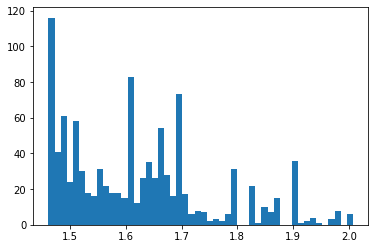

In [ ]:
score_list = list(rec_book["score"])

plt.hist(score_list, bins=50)

# Final Model V2 without Cover

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def title_similarity(eval_title, final_rec_df):
  #print(eval_title)
  final_rec_df.reset_index(inplace=True)
  books = final_rec_df["title"]
  #corpus = final_rec_df["title"].to_list()
  # Create TfidfVectorizer object
  vectorizer = TfidfVectorizer()

  # Generate matrix of word vectors
  tfidf_matrix = vectorizer.fit_transform(books)
  cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
  
  indices = pd.Series(final_rec_df.index, index=final_rec_df['title']).drop_duplicates()
  #print(indices)
  # Get the index of the books that matches the title
  idx = indices[eval_title]

  #if type(idx) == pd.Series:
  #    idx = idx[0]
  #print(idx)
  # Get the pairwsie similarity scores
  sim_scores = list(enumerate(cosine_sim[idx]))
  # Sort the titles based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  # Get the scores for 10 most similar titles
  sim_scores = sim_scores[1:6]
  # Get the title indices
  book_indices = [i[0] for i in sim_scores]
  titles = final_rec_df['title'].iloc[book_indices]
  
  #recommend = books.iloc[book_indices]
  # Return the top 5 most similar title
  return items_df.loc[items_df.title.isin(titles)].index.to_list()


In [ ]:
def get_final_recommendation(eval_id, topic_matrix):
    '''
    currently some functions take eval_id as string, others as integer; standardization would be great but on the other hand isn't really necessary. Currently build with input as integer
    filter for books in same language ; comment Tobi: we should probably discuss whether we want to do this in all cases. A book by the same author in another language might still be a better recommendation than something that comes up at the very last step of out current model

    ### model flow codebook ### Feel free to adapt this if you come up with a more intuitive idea of following the model flow for each book 
    number = number of books added/ taken into consideration in this step
    seq = sequel_identifier+number
    tsa = total same author+number
    a = author+number
    '''
    

    eval_book = items_df[items_df.index == str(eval_id)]
    eval_title = str(eval_book["title"].values[0])
    #eval_title= eval_book["title"]

    #print(eval_title)
    eval_language = eval_book.loc[str(eval_id), "language"]
    rec_candidates = items_df[items_df["language"] == eval_language]
    model_flow = ""
    # trans_df_same_language = pd.merge(trans_df_clean, rec_candidates, on="itemID", right_index=True)

    # sequel identifier
    final_rec = get_sequel_book(int(eval_id), rec_candidates, eval_df, get_sequel_series = True, get_prequels = False)
    final_candidates = []
    
    if len(final_rec) == 5:
        model_flow = "seq" + str(len(final_rec)) 
        return final_rec, final_candidates, model_flow

    if len(final_rec) < 5:
        final_rec = get_sequel_book(int(eval_id), rec_candidates, eval_df, get_sequel_series = True, get_prequels = True)
        model_flow = "seqpreq" + str(len(final_rec)) 
        if len(final_rec) == 5:
            return final_rec, final_candidates, model_flow

    if len(final_rec) > 5:
      
    
      if eval_id in items_filtered.index.to_list():
        output_w2v, sim_scores_w2v =title_recommendations(eval_title, items_filtered, array_embeddings=word_embeddings, threshold=0)
        output_w2v = output_w2v.tolist()
        final_rec = [id for id in output_w2v if id in final_rec][:5]
        model_flow = "seqw2v" + str(len(final_rec)) 
        return final_rec, final_candidates, model_flow

      else:
        final_rec.append(str(eval_id))
        #print(final_rec, len(final_rec))
        final_rec_df = items_df[items_df.index.isin(final_rec)]
        #return final_rec_df
        final_rec = title_similarity(eval_title, final_rec_df)
        return final_rec, final_candidates, model_flow

    rec_candidates = rec_candidates[~rec_candidates.index.isin(final_rec)] # remove books that are already recommended

    rec_candidates = rec_candidates[~((rec_candidates["title"] == eval_book.loc[str(eval_id), "title"]) & (rec_candidates["author"] == eval_book.loc[str(eval_id), "author"].lower()))]
    
    if eval_title in items_filtered.title.to_list():
      output_w2v, sim_scores_w2v = title_recommendations(title=eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=0.999)
      output_w2v = output_w2v.tolist()
      rec_candidates = rec_candidates.loc[(~rec_candidates.index.isin(output_w2v)) | (rec_candidates["author"] != str(eval_book["author"]))]
    rec_candidates = rec_candidates.append(eval_book)


    # get all books by same author
    rec_candidates_author = get_author_recommendations(str(eval_id), rec_candidates, num = 999)
    model_flow = model_flow + "tsa" + str(len(rec_candidates_author)) +"_"

    if len(rec_candidates_author) + len(final_rec) == 5:
        final_rec.extend(rec_candidates_author.index.tolist())
        model_flow = model_flow + "a" + str(len(rec_candidates_author))
        return final_rec, final_candidates, model_flow

    # add all books from same author to final_rec if all prior steps + this one lead to len(final_rec) == 5
    if (len(final_rec) + len(rec_candidates_author) <= 50) & (len(final_rec) + len(rec_candidates_author) > 5):
        final_candidates.extend(rec_candidates_author.index.tolist())
        model_flow = model_flow + "a" + str(len(rec_candidates_author)) + "_"
        return final_rec, final_candidates, model_flow

    elif (len(final_rec) + len(rec_candidates_author)) < 5:
        rec_candidates = rec_candidates[~rec_candidates.index.isin(final_rec)]
        # print(rec_candidates)
        n_slots = 50
        #Go to case for all books (not same author)
        print("Begin branch 1")
        if n_slots > 0: 
          # check if eval_id in trans_df          
          if eval_id in trans_df_clean.itemID.to_list():
            print("Begin KNN")
            X, session_mapper, item_mapper, session_inv_mapper, item_inv_mapper = create_X(trans_df_clean)
            #print(eval_id in trans_df_clean.)
            neighbor_ids, neighbor_distance = get_similar_items(eval_id, X, k=n_slots)
            output_knn = tuple(zip(neighbor_ids, neighbor_distance.tolist()))
            neighbor_ids = [id for (id, dist) in output_knn if dist < 0.99 and id in rec_candidates.index.tolist()]
            final_candidates.extend(neighbor_ids) # Append KNN output to candidates for transaction imitator.
            
            if len(final_candidates) == 50:
              model_flow = model_flow + "knn" + str(len(neighbor_ids))
              return final_rec, final_candidates, model_flow

            model_flow = model_flow + "knn" + str(len(neighbor_ids)) + "_"
            
          # Fill other slots with other modules.
          if len(final_candidates) < 50:
            n_slots = 50 - len(final_candidates)
            print("Begin similar author and similar topic candidates based on transaction model")
            # if author of eval_id is frequently bought with books of other authors: --> Work with similar authors
            similar_authors = get_similar_author(eval_id, 0.25)
            #association rules based on topics) --> topics base on trasnaction
            similar_topics = get_similar_topic(eval_id, 0.4).index.tolist()
            if (len(similar_authors) != 0) | (len(similar_topics) != 0):
              similar_author_df = rec_candidates[rec_candidates.author.isin(similar_authors)]
              
              similar_topics_df = rec_candidates[rec_candidates["main topic"].isin(similar_topics)]
            
              similar_author_df = similar_author_df.append(similar_topics_df)
              similar_author_df = similar_author_df[similar_author_df["language"]==eval_language]
              #print(len(similar_author_df))
              if len(similar_author_df) <= n_slots:                
                final_candidates.extend(similar_author_df.index.tolist())
                model_flow = model_flow + "sima" + str(len(similar_author_df)) +"_"
                n_slots = 50 - len(final_candidates)
                rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates.index.tolist(), N=max(50-len(final_candidates),0))
                #print(len(rec_candidates_topics_df))
                rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
                if len(rec_candidates_topics_id) != 0:
                  rec_candidates = rec_candidates[rec_candidates.index.isin(rec_candidates_topics_id)]
                  print(len(rec_candidates))
                  #if len(rec_candidates) < n_slots:
                    #rec_candidates_topics_df.rename(columns={"id":"itemID"})
                  #  rec_candidates = rec_candidates_topics_df.rename(columns={"id":"itemID"})
                  if len(rec_candidates) >= n_slots:
                    final_candidates.extend(rec_candidates.index.tolist()[:n_slots])
                    return final_rec, final_candidates, model_flow
              else:
                rec_candidates = similar_author_df
              #rec_candidates.append(similar_topics_df)
              print("End of transaction model")
  
            # Topic Module
            print("Begin topic module")
            #print(len(rec_candidates))
            rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates.index.tolist(), N=min(n_slots*2,len(rec_candidates)))
            #print(len(rec_candidates_topics_df))
            #print(len(rec_candidates_topics_df))
            # take only books with max score
            # tmp = rec_candidates_topics_df[rec_candidates_topics_df["score"] == max(rec_candidates_topics_df["score"])]
            #print(len(tmp)) 
            # if len(tmp) <= 50:
            #   rec_candidates_topics_df.sort_values(["score"], ascending=False).head(50)
            # else:
            #   rec_candidates_topics_df = tmp
              #print(len(rec_candidates_topics_df))
            rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
            if len(rec_candidates_topics_id) != 0:
              rec_candidates = rec_candidates[rec_candidates.index.isin(rec_candidates_topics_id)]
              #if len(rec_candidates) < n_slots:
                #rec_candidates_topics_df.rename(columns={"id":"itemID"})
              #  rec_candidates = rec_candidates_topics_df.rename(columns={"id":"itemID"})
              #print(len(rec_candidates))
              #print(len(rec_candidates))
            #rec_candidates = get_topic_candidates(eval_id, str(eval_book["main topic"]), rec_candidates, similarity_matrix=topic_similarity_matrix, n=5)
            print(len(rec_candidates))
            print("End of topic module")  
            #print(len(rec_candidates))
            #rec_candidates_copy = rec_candidates.copy()
            
            Y = 0.75
            #Z = 0.75
            if eval_title in items_filtered.title.to_list():
              if (len(rec_candidates) >= n_slots):
                print("Begin title module")                
                output_w2v, sim_scores_w2v = title_recommendations(title=eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=Y)
                output_w2v = output_w2v.tolist()
                rec_candidates_titles = [id for id in output_w2v if id in rec_candidates.index.tolist()]
                #print(len(rec_candidates_titles))
                if len(rec_candidates_titles) > 0:
                  title_recomm = pd.DataFrame(list(zip(rec_candidates_titles, sim_scores_w2v)),columns =['itemID', 'score_title'])
                  rec_candidates_titles_df = pd.merge(title_recomm, rec_candidates, on = "itemID")
                  rec_candidates_titles_df.sort_values(by=['score_title'], ascending=False, inplace =True)
                  rec_candidates_titles_df = rec_candidates_titles_df.iloc[:n_slots, ]
                  
                  final_candidates.extend(rec_candidates_titles_df.index.to_list())
                  model_flow = model_flow + "title" + str(len(rec_candidates_titles_df)) + "_"
                  n_slots = n_slots - len(rec_candidates_titles_df)
                else:
                  final_candidates.extend(rec_candidates.index.tolist()[:n_slots])
              #print(len(rec_candidates))
              print("End title module")
            else:
              final_candidates.extend(rec_candidates.index.tolist()[:n_slots])
              model_flow = model_flow + "from"+ str(len(rec_candidates)) +"_topn" + str(n_slots)
          print(model_flow)

          return final_rec, final_candidates, model_flow
          
          
          # Narrow down using other modules.            
          if len(final_candidates) > 50:
            final_candidates = final_candidates[:50]
            return final_rec, final_candidates, model_flow


    else: #final_rec+rec_candidates_author > 5 --> filter rec_candidates_author down to 5-len(final_rec)
        print("Begin 2.Branch")
        threshold=0.75

        rec_candidates_title = []

        if eval_title in items_filtered.title.to_list():
          print("Begin title modul")
          while len(final_candidates)+len(rec_candidates_title) < 50:
              
              #eval_title = items_df.loc[eval_id, "title"]
              output_w2v, sim_scores_w2v = title_recommendations(title=eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=threshold)
              output_w2v = output_w2v.tolist()
              rec_candidates_title = rec_candidates_author.loc[(rec_candidates_author["title"].isin(output_w2v)) & (rec_candidates_author["language"]==eval_language)]
              threshold -= 0.05

          if len(rec_candidates_title)+len(final_candidates) == 50:
              final_candidates += rec_candidates_title.index.tolist()
              model_flow = model_flow + "title" + str(len(rec_candidates_title)) + "_"
              print(model_flow)
              print("End of title modul")
              return final_rec, final_candidates, model_flow

          else:
              rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates_title.index.tolist() ,N=max(50-len(final_candidates),0))
              rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
              # random_rec = np.random.choice(np.array(rec_candidates_title.index.tolist()), size=max(50-len(final_rec),0), replace=False).tolist()
                #np.random.choice(np.array(rec_candidates.index.tolist()), size=5-len(final_rec), replace=False).tolist()
                
              final_candidates.extend(rec_candidates_topics_id)
              model_flow = model_flow + "title->topic" + str(len(rec_candidates_topics_id)) + "_"
              print("End of title modul")
        else:
              rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates_author.index.tolist() ,N=max(50-len(final_candidates),0))
              rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
              # random_rec = np.random.choice(np.array(rec_candidates_author.index.tolist()), size=max(50-len(final_rec),0), replace=False).tolist()
                #np.random.choice(np.array(rec_candidates.index.tolist()), size=5-len(final_rec), replace=False).tolist()
                
              final_candidates.extend(rec_candidates_topics_id)
              model_flow = model_flow + "author->topic" + str(len(rec_candidates_topics_id)) + "_"
        print("End branch 2")
        print(model_flow)

    return final_rec, final_candidates, model_flow

In [ ]:
# Not for use
def get_final_recommendation(eval_id, topic_matrix):
    '''
    currently some functions take eval_id as string, others as integer; standardization would be great but on the other hand isn't really necessary. Currently build with input as integer
    filter for books in same language ; comment Tobi: we should probably discuss whether we want to do this in all cases. A book by the same author in another language might still be a better recommendation than something that comes up at the very last step of out current model

    ### model flow codebook ### Feel free to adapt this if you come up with a more intuitive idea of following the model flow for each book 
    number = number of books added/ taken into consideration in this step
    seq = sequel_identifier+number
    tsa = total same author+number
    a = author+number
    '''
    

    eval_book = items_df[items_df.index == str(eval_id)]
    eval_title = str(eval_book["title"])
    eval_language = eval_book.loc[str(eval_id), "language"]
    rec_candidates = items_df[items_df["language"] == eval_language]
    # trans_df_same_language = pd.merge(trans_df_clean, rec_candidates, on="itemID", right_index=True)

    # sequel identifier
    final_rec = get_sequel_book(int(eval_id), rec_candidates, eval_df, get_sequel_series = True, get_prequels = False)
    final_candidates = []
    
    if len(final_rec) == 5:
        model_flow = "seq" + str(len(final_rec)) 
        return final_rec, final_candidates, model_flow

    if len(final_rec) < 5:
        final_rec = get_sequel_book(int(eval_id), rec_candidates, eval_df, get_sequel_series = True, get_prequels = True)
        model_flow = "seqpreq" + str(len(final_rec)) 
        if len(final_rec) == 5:
            return final_rec, final_candidates, model_flow

    if len(final_rec) > 5:
        output_w2v, sim_scores_w2v =title_recommendations(eval_title, items_filtered, array_embeddings=word_embeddings, threshold=0)
        output_w2v = output_w2v.tolist()
        final_rec = [id for id in output_w2v if id in final_rec][:5]
        model_flow = "seqw2v" + str(len(final_rec)) 
        return final_rec, final_candidates, model_flow
    
    rec_candidates = rec_candidates[~rec_candidates.index.isin(final_rec)] # remove books that are already recommended

    rec_candidates = rec_candidates[~((rec_candidates["title"] == eval_book.loc[str(eval_id), "title"]) & (rec_candidates["author"] == eval_book.loc[str(eval_id), "author"]))]
    
    if eval_title in items_filtered.title.to_list():
      output_w2v, sim_scores_w2v = title_recommendations(title=eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=0.999)
      output_w2v = output_w2v.tolist()
      rec_candidates = rec_candidates.loc[(~rec_candidates.index.isin(output_w2v)) | (rec_candidates["author"] != str(eval_book["author"]))]
    rec_candidates = rec_candidates.append(eval_book)


    # get all books by same author
    rec_candidates_author = get_author_recommendations(str(eval_id), rec_candidates, num = 999)
    model_flow = model_flow + "tsa" + str(len(rec_candidates_author)) +"_"

    if len(rec_candidates_author) + len(final_rec) == 5:
        final_rec.extend(rec_candidates_author.index.tolist())
        model_flow = model_flow + "a" + str(len(rec_candidates_author))
        return final_rec, final_candidates, model_flow

    # add all books from same author to final_rec if all prior steps + this one lead to len(final_rec) == 5
    if (len(final_rec) + len(rec_candidates_author) <= 50) & (len(final_rec) + len(rec_candidates_author) > 5):
        final_candidates.extend(rec_candidates_author.index.tolist())
        model_flow = model_flow + "a" + str(len(rec_candidates_author)) + "_"
        return final_rec, final_candidates, model_flow

    elif (len(final_rec) + len(rec_candidates_author)) < 5:
        rec_candidates = rec_candidates[~rec_candidates.index.isin(final_rec)]
        # print(rec_candidates)
        n_slots = 50
        #Go to case for all books (not same author)
        print("Begin branch 1")
        if n_slots > 0: 
          # check if eval_id in trans_df          
          if eval_id in trans_df.itemID.to_list():
            print("Begin KNN")
            X, session_mapper, item_mapper, session_inv_mapper, item_inv_mapper = create_X(trans_df_clean)
            neighbor_ids, neighbor_distance = get_similar_items(eval_id, X, k=n_slots)
            output_knn = tuple(zip(neighbor_ids, neighbor_distance.tolist()))
            neighbor_ids = [id for (id, dist) in output_knn if dist < 0.99 and id in rec_candidates.index.tolist()]
            final_candidates.extend(neighbor_ids) # Append KNN output to candidates for transaction imitator.
            
            if len(final_candidates) == 50:
              model_flow = model_flow + "knn" + str(len(neighbor_ids))
              return final_rec, final_candidates, model_flow

            model_flow = model_flow + "knn" + str(len(neighbor_ids)) + "_"
            
          # Fill other slots with other modules.
          if len(final_candidates) < 50:
            n_slots = 50 - len(final_candidates)
            print("Begin similar author and similar topic candidates based on transaction model")
            # if author of eval_id is frequently bought with books of other authors: --> Work with similar authors
            similar_authors = get_similar_author(eval_id, 0.25)
            #association rules based on topics) --> topics base on trasnaction
            similar_topics = get_similar_topic(eval_id, 0.4).index.tolist()
            if (len(similar_authors) != 0) | (len(similar_topics) != 0):
              similar_author_df = rec_candidates[rec_candidates.author.isin(similar_authors)]
              
              similar_topics_df = rec_candidates[rec_candidates["main topic"].isin(similar_topics)]
            
              similar_author_df = similar_author_df.append(similar_topics_df)
              similar_author_df = similar_author_df[similar_author_df["language"]==eval_language]
              
              if len(similar_author_df) <= n_slots:                
                final_candidates.extend(similar_author_df.index.tolist())
                model_flow = model_flow + "sima" + str(len(similar_author_df)) +"_"
                n_slots = 50 - len(final_candidates)
                rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates.index.tolist(), N=50)
                rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
                if len(rec_candidates_topics_id) != 0:
                  rec_candidates = rec_candidates[rec_candidates.index.isin(rec_candidates_topics_id)]
                  if len(rec_candidates) < n_slots:
                    #rec_candidates_topics_df.rename(columns={"id":"itemID"})
                    rec_candidates = rec_candidates_topics_df.rename(columns={"id":"itemID"})

              else:
                rec_candidates = similar_author_df
              #rec_candidates.append(similar_topics_df)
              print("End of transaction model")
  
            # Topic Module
            print("Begin topic module")
            rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates.index.tolist(), N=min(n_slots*2,len(rec_candidates)))
            #print(len(rec_candidates_topics_df))
            # take only books with max score
            # tmp = rec_candidates_topics_df[rec_candidates_topics_df["score"] == max(rec_candidates_topics_df["score"])]
            #print(len(tmp)) 
            # if len(tmp) <= 50:
            #   rec_candidates_topics_df.sort_values(["score"], ascending=False).head(50)
            # else:
            #   rec_candidates_topics_df = tmp
              #print(len(rec_candidates_topics_df))
            rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
            if len(rec_candidates_topics_id) != 0:
              rec_candidates = rec_candidates[rec_candidates.index.isin(rec_candidates_topics_id)]
              if len(rec_candidates) < n_slots:
                #rec_candidates_topics_df.rename(columns={"id":"itemID"})
                rec_candidates = rec_candidates_topics_df.rename(columns={"id":"itemID"})
              #print(len(rec_candidates))
              #print(len(rec_candidates))
            #rec_candidates = get_topic_candidates(eval_id, str(eval_book["main topic"]), rec_candidates, similarity_matrix=topic_similarity_matrix, n=5)
            print("End of topic module")  
            #print(len(rec_candidates))
            #rec_candidates_copy = rec_candidates.copy()
            
            Y = 0.75
            #Z = 0.75
            if eval_title in items_filtered.title.to_list():
              if (len(rec_candidates) >= n_slots):
                print("Begin title module")                
                output_w2v, sim_scores_w2v = title_recommendations(title=eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=Y)
                output_w2v = output_w2v.tolist()
                rec_candidates_titles = [id for id in output_w2v if id in rec_candidates["itemID"].tolist()]
                if len(rec_candidates_titles) > 0:
                  title_recomm = pd.DataFrame(list(zip(rec_candidates_titles, sim_scores_w2v)),columns =['itemID', 'score_title'])
                  rec_candidates_titles_df = pd.merge(title_recomm, rec_candidates, on = "itemID")
                  rec_candidates_titles_df.sort_values(by=['score_title'], ascending=False, inplace =True)
                  rec_candidates_titles_df = rec_candidates_titles_df.iloc[:n_slots, ]
                  
                  final_candidates.extend(rec_candidates_titles_df.index.to_list())
                  model_flow = model_flow + "title" + str(len(rec_candidates_titles_df)) + "_"
                  n_slots = n_slots - len(rec_candidates_titles_df)
              #print(len(rec_candidates))
              print("End title module")
            else:
              final_candidates.extend(rec_candidates.index.tolist()[:n_slots])
              model_flow = model_flow + "from"+ str(len(rec_candidates)) +"_topn" + str(n_slots)
          print(model_flow)
          return final_rec, final_candidates, model_flow
          
          
          # Narrow down using other modules.            
          if len(final_candidates) > 50:
            final_candidates = final_candidates[:50]
            return final_rec, final_candidates, model_flow






        #   n_slots = 50 - len(final_candidates)
        #   model_flow = model_flow + "knn" + str(len(neighbor_ids)) + "_"
        #   print("End of KNN")
        #   if n_slots == 0:
        #     print(model_flow)
        #     return final_rec, model_flow


        # if n_slots > 0:
        #   print("Begin similar author and similar topic candidates based on transaction model")
        #   # if author of eval_id is frequently bought with books of other authors: --> Work with similar authors
        #   similar_authors = get_similar_author(eval_id, 0.25)
        #   #association rules based on topics) --> topics base on trasnaction
        #   similar_topics = get_similar_topic(eval_id, 0.4).index.tolist()
        #   if (len(similar_authors) != 0) | (len(similar_topics) != 0):
        #     similar_author_df = rec_candidates[rec_candidates.author.isin(similar_authors)]
            
        #     similar_topics_df = rec_candidates[rec_candidates["main topic"].isin(similar_topics)]
            
        #     similar_author_df = similar_author_df.append(similar_topics_df)
            
        #     if len(similar_author_df) <= n_slots:
              
        #       final_rec.extend(similar_author_df.index.tolist())
        #       model_flow = model_flow + "sima" + str(len(similar_author_df)) +"_"
        #       n_slots = 50 - len(final_rec)
        #       rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, N=50)
        #       rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
        #       if len(rec_candidates_topics_id) != 0:
        #         rec_candidates = rec_candidates[rec_candidates.index.isin(rec_candidates_topics_id)]
        #         if len(rec_candidates) < n_slots:
        #           #rec_candidates_topics_df.rename(columns={"id":"itemID"})
        #           rec_candidates = rec_candidates_topics_df.rename(columns={"id":"itemID"})
        #     else:
        #       rec_candidates = similar_author_df
        #     #rec_candidates.append(similar_topics_df)
        #     print("End of transaction model")
        #   else:  
        #     print("Begin topic module")
        #     rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, N=50)
        #     #print(len(rec_candidates_topics_df))
        #     # take only books with max score
        #     # tmp = rec_candidates_topics_df[rec_candidates_topics_df["score"] == max(rec_candidates_topics_df["score"])]
        #     #print(len(tmp)) 
        #     # if len(tmp) <= 50:
        #     #   rec_candidates_topics_df.sort_values(["score"], ascending=False).head(50)
        #     # else:
        #     #   rec_candidates_topics_df = tmp
        #       #print(len(rec_candidates_topics_df))
        #     rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
        #     if len(rec_candidates_topics_id) != 0:
        #       rec_candidates = rec_candidates[rec_candidates.index.isin(rec_candidates_topics_id)]
        #       if len(rec_candidates) < n_slots:
        #         #rec_candidates_topics_df.rename(columns={"id":"itemID"})
        #         rec_candidates = rec_candidates_topics_df.rename(columns={"id":"itemID"})
        #       #print(len(rec_candidates))
        #   #print(len(rec_candidates))
        #     #rec_candidates = get_topic_candidates(eval_id, str(eval_book["main topic"]), rec_candidates, similarity_matrix=topic_similarity_matrix, n=5)
        #     print("End of topic module")  
        #   #print(len(rec_candidates))
        #   #rec_candidates_copy = rec_candidates.copy()
          
        #   Y = 0.75
        #   #Z = 0.75
        #   if eval_title in items_filtered.title.to_list():
        #     if (len(rec_candidates) >= n_slots):
        #       print("Begin title module")
        #       rec_candidates_titles, sim_scores_w2v = title_recommendations(eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=Y)
        #       if len(rec_candidates_titles) > 0:
        #         title_recomm = pd.DataFrame(list(zip(rec_candidates_titles, sim_scores_w2v)),columns =['itemID', 'score_title'])
        #         rec_candidates_titles_df = pd.merge(title_recomm, rec_candidates, on = "itemID")
        #         rec_candidates_titles_df.sort_values(by=['score_title'], ascending=False, inplace =True)
        #         rec_candidates_titles_df = rec_candidates_titles_df.iloc[:n_slots, ]
                
        #         final_rec.extend(rec_candidates_titles_df.index.to_list())
        #         model_flow = model_flow + "title" + str(len(rec_candidates_titles_df)) + "_"
        #         n_slots = n_slots - len(rec_candidates_titles_df)
        #     #print(len(rec_candidates))
        #     print("End title module")
        #   else:
        #     print("Begin cover similarity with " + str(len(rec_candidates)))
        #     print(model_flow)
        #     if len(final_rec) < 50:
        #       #while (len(rec_candidates_copy) < 5):
        #       #  print("end")
        #         #rec_candidates_cover = cover_comparison(eval_id, rec_candidates_copy.index.to_list(), Z)
        #         #rec_candidates_cover = rec_candidates_cover.iloc[:n_slots, ]
        #       # print(rec_candidates)
        #       random_rec = np.random.choice(np.array(rec_candidates.itemID.tolist()), size=n_slots, replace=False).tolist()
        #       #np.random.choice(np.array(rec_candidates.index.tolist()), size=5-len(final_rec), replace=False).tolist()
              
        #       final_rec.extend(random_rec)
            
        #       model_flow = model_flow + "from_"+ str(len(rec_candidates)) +"random_" + str(len(random_rec)) + "_"
        #     print("End cover similarity")
        # print(model_flow)
        # return final_rec, model_flow


    else: #final_rec+rec_candidates_author > 5 --> filter rec_candidates_author down to 5-len(final_rec)
        print("Begin 2.Branch")
        threshold=0.75

        rec_candidates_title = []

        if eval_title in items_filtered.title.to_list():
          print("Begin title modul")
          while len(final_candidates)+len(rec_candidates_title) < 50:
              
              #eval_title = items_df.loc[eval_id, "title"]
              output_w2v, sim_scores_w2v = title_recommendations(title=eval_title, df=items_filtered, array_embeddings=word_embeddings, threshold=threshold)
              output_w2v = output_w2v.tolist()
              rec_candidates_title = rec_candidates_author.loc[(rec_candidates_author["title"].isin(output_w2v)) & (rec_candidates_author["language"]==eval_language)]
              threshold -= 0.05

          if len(rec_candidates_title)+len(final_candidates) == 50:
              final_candidates += rec_candidates_title.index.tolist()
              model_flow = model_flow + "title" + str(len(rec_candidates_title)) + "_"
              print(model_flow)
              print("End of title modul")
              return final_rec, final_candidates, model_flow

          else:
              rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates_title.index.tolist() ,N=max(50-len(final_candidates),0))
              rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
              # random_rec = np.random.choice(np.array(rec_candidates_title.index.tolist()), size=max(50-len(final_rec),0), replace=False).tolist()
                #np.random.choice(np.array(rec_candidates.index.tolist()), size=5-len(final_rec), replace=False).tolist()
                
              final_candidates.extend(rec_candidates_topics_id)
              model_flow = model_flow + "title->topic" + str(len(rec_candidates_topics_id)) + "_"
              print("End of title modul")
        else:
              rec_candidates_topics_df = get_all_topics_dict(eval_id, topic_matrix, rec_candidates_author.index.tolist() ,N=max(50-len(final_candidates),0))
              rec_candidates_topics_id = rec_candidates_topics_df.id.astype("str").tolist()
              # random_rec = np.random.choice(np.array(rec_candidates_author.index.tolist()), size=max(50-len(final_rec),0), replace=False).tolist()
                #np.random.choice(np.array(rec_candidates.index.tolist()), size=5-len(final_rec), replace=False).tolist()
                
              final_candidates.extend(rec_candidates_topics_id)
              model_flow = model_flow + "author->topic" + str(len(rec_candidates_topics_id)) + "_"
        print("End branch 2")
        print(model_flow)

    return final_rec, final_candidates, model_flow

In [ ]:
#eval_id = items_df.loc[items_df["author"]==author].index.tolist()[0]
eval_id = "12"
errors = []
try:
  get_final_recommendation(eval_id, topic_matrix)
except:
  errors.append(eval_id)
#eval_title = items_df.loc[eval_id, "title"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
Begin cover similarity with 55
seq0_tsa0_a0_
End cover similarity
seq0_tsa0_a0_from_55random_50_


In [ ]:
eval_df.tail()

""
itemID
78384
68157
44964
12971
41078


In [ ]:
final_rec, final_candidates, modelflow = get_final_recommendation('44964', topic_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
final_candidates

['21218', '26648', '65060', '45452', '74918', '3817']

In [ ]:
final_rec, final_candidates, modelflow

(['66167', '19503', '21470', '55547', '22190'], [], 'seqpreq0tsa5_a5')

In [ ]:
eval_df.tail()

""
itemID
78384
68157
44964
12971
41078


In [ ]:
items_df.loc["68157"]

title                                      Der ewige Krieg
author                                        Joe Haldeman
publisher                                Heyne Taschenbuch
main topic                                             FLR
subtopics                                FJM, FLR, FM, FYT
desc                                                   nan
title_cleaned                              der ewige krieg
authors_list                                [joe haldeman]
language_qualifier                                     nan
language_title                                          de
score_language_title                              0.936835
language_desc                                          nan
score_language_desc                                      0
language                                                de
topics_list                            [FM, FLR, FJM, FYT]
topics_list_split       [FM, FLR, FY, FJM, FL, F, FJ, FYT]
Name: 68157, dtype: object

In [ ]:
items_df.loc[final_rec]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
66167,Herr der Zeit,Joe Haldeman,Mantikore Verlag,FLG,,nan,herr der zeit,[joe haldeman],nan,de,0.991278,nan,0.000000,de,"[, FLG]","[FLG, FL, F]"
19503,Camouflage: Ein Science Fiction Roman von Joe ...,Joe Haldeman,Mantikore Verlag,FLU,FLP,nan,camouflage ein science fiction roman von joe h...,[joe haldeman],nan,de,0.968549,nan,0.000000,de,"[FLP, FLU]","[FLP, FL, F, FLU]"
21470,Marsbound (dt. Ausgabe),Joe Haldeman,Mantikore Verlag,FL,,Rebellious young Carmen Dula joins her family ...,marsbound dt ausgabe,[joe haldeman],nan,de,0.989599,en,0.959721,de,"[, FL]","[FL, F]"
55547,Starbound (dt. Ausgabe),Joe Haldeman,Mantikore Verlag,FL,,"""Wir sind nicht allein!"" Carmen Dula gehÃ¶rt z...",starbound dt ausgabe,[joe haldeman],nan,de,0.996856,de,0.993930,de,"[, FL]","[FL, F]"
22190,Camouflage,Joe Haldeman,Mantikore Verlag,FLP,"5AQ, FLU","An unidentified artifact, found seven miles be...",camouflage,[joe haldeman],nan,de,0.665875,en,0.923416,de,"[FLP, 5AQ, FLU]","[FLU, 5AQ, 5A, 5, FLP, FL, F]"


In [ ]:
eval_ids = eval_df[eval_df.index.isin(items_df.index.tolist())]
len(eval_ids)

998

In [ ]:
eval_ids = eval_df.index.to_list()
final_rec_dict = {}
final_cand_dict = {}
flow_dict = {}
errors = []
#recommendations_df = pd.DataFrame([], eval_df.index.tolist(),columns=["rec_1","rec_2","rec_3","rec_4","rec_5"])
for index, id in enumerate(eval_ids):
  print(index, id)
  try:
    final_rec_dict[id], final_cand_dict[id], flow_dict[id] = get_final_recommendation(id, topic_matrix)
  except:
    errors.append(id)
  #comm, flow = get_final_recommendation(id, topic_similarity_matrix)
  #comm = pd.DataFrame([comm], columns=["rec_1","rec_2","rec_3","rec_4","rec_5"])
  #recommendations_df = pd.concat([recommendations_df,comm])

0 12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
1 45274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


2 10104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from179_topn50
3 41371
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_sima0_from67_topn50
4 14015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


5 28515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
6 70766
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
7 1822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from125_topn50
8 56794
9 60188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


10 62060


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn1_sima0_from50_topn49
11 31401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
12 6420


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from106_topn50
13 72855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
14 73378


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


15 25049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from148_topn50
16 24603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


17 5737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


18 38980
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima25_from54_topn25
19 13382
20 75121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


21 39779


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
22 14026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


23 9392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


24 77956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


25 70300
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from101_topn50
26 77134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


27 75340


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from106_topn50
28 51066
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from224_topn50
29 67776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn10_sima0_from53_topn40
30 53929
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn32_sima0_from249_topn18
31 22342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
32 41116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from100_topn50
33 60331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


34 65307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


35 50039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
36 42184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa222_author->topic52_
37 76163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


38 2319
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn8_sima0_from53_topn42
39 62494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa0_knn14_sima0_from50_topn36
40 31015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from100_topn50
41 21497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq4tsa0_knn13_from79_topn37
42 53008
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn15_sima0_from170_topn35
43 39308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn1_from98_topn49
44 4690
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn20_from65_topn30
45 19777


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from108_topn50
46 10078
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa1_from103_topn50
47 65353
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn26_sima0_from53_topn24
48 58847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from125_topn50
49 61593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn47_sima0_from8_topn3
50 18537
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
51 73427
52 7521


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


53 71586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq4tsa0_from140_topn50
54 13772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


55 33092


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa56_author->topic53_
56 74398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


57 74089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from112_topn50
58 57282


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq3tsa0_from136_topn50
59 38760
60 15657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from129_topn50
61 17665
62 75251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

63 56282
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn16_from68_topn34
64 73973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from142_topn50
65 19994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from101_topn50
66 47098


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


67 54190


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
68 61043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
69 78675
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
70 40394
Begin 2.Branch
End branch 2
seqpreq0tsa68_author->topic58_
71 43844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from104_topn50
72 27300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from171_topn50
73 22870


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


74 61707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
75 17888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from161_topn50
76 48292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from91_topn50
77 2054


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from51_topn50
78 6643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


79 3857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from270_topn50
80 64350
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_sima0_from170_topn45
81 10833


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


82 33556
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn41_from32_topn9
83 23256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from112_topn50
84 53880
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from231_topn50
85 75694
86 17770


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa54_author->topic50_
87 9365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq1tsa1_from148_topn50
88 11177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from124_topn50
89 48659
90 18169


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


91 48490


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from112_topn50
92 70627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from106_topn50
93 40000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


94 18665
95 35574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from105_topn50
96 11732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq2tsa0_from112_topn50
97 6798
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn4_from170_topn46
98 42415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from123_topn50
99 64236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
100 60644
101 11595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from106_topn50
102 39957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


103 1519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from106_topn50
104 10075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from112_topn50
105 25209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
106 7108


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
107 67848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from136_topn50
108 40424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


109 72523
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn42_from16_topn8
110 60588
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from224_topn50
111 21315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from385_topn50
112 50356
113 75904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from102_topn50
114 17240


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn0_from102_topn50
115 24218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
116 21949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


117 6478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from142_topn50
118 76242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from91_topn50
119 71112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from161_topn50
120 76437
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
121 52656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from120_topn50
122 10304
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
123 25399
124 71619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn47_from6_topn3
125 31439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


126 14323
127 10842
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from78_topn50
128 39515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


129 59732
130 56452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


131 53496
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa2_from103_topn50
132 27903
133 53672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa85_author->topic50_
134 29813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from204_topn50
135 67909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


136 36620
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn35_from30_topn15
137 44197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
138 68772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn0_from123_topn50
139 72058
140 17921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from170_topn50
141 67832
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn3_from197_topn47
142 73203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from123_topn50
143 30873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq1tsa0_from348_topn50
144 46059
145 49615


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa85_author->topic62_
146 76629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
147 55488
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn4_from140_topn46
148 30713
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn32_sima0_from39_topn18
149 3527
150 52884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from118_topn50
151 48270
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from124_topn50
152 18224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


153 39309


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


154 11265
155 8288


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from124_topn50
156 40312


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


157 35418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
158 78181
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn9_sima0_from54_topn41
159 8859
Begin branch 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from170_topn50
160 3875
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from249_topn50
161 17348
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn19_from62_topn31
162 37321
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from224_topn50
163 22277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_sima16_from132_topn34
164 52705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from136_topn50
165 26856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from163_topn50
166 36095
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn14_from231_topn36
167 66497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq2tsa1_sima0_from50_topn50
168 55326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
169 3959
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn9_from249_topn41
170 66928


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


171 23159
172 76762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


173 73748
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from170_topn50
174 8248
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from170_topn50
175 39766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
176 49234
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn27_sima0_from56_topn23
177 23366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


178 59734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from137_topn50
179 41020


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


180 74389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
181 8538
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_sima0_from170_topn50
182 40113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


183 32980


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
184 47068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
185 20083
186 31728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_sima0_from50_topn50
187 52192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
188 62732
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn18_from249_topn32
189 30746
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from170_topn50
190 22622


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from101_topn50
191 54612


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


192 59032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


193 26385
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
194 65461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from103_topn50
195 54835


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


196 54737
197 76905
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa1_from101_topn50
198 45093
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from247_topn50
199 31273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa4_sima0_from51_topn50
200 851
201 16935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_sima0_from58_topn43
202 28379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


203 17009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from203_topn50
204 1486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from118_topn50
205 62630


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from131_topn50
206 34682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


207 6741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


208 20852
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
209 22265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
210 2244
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_sima0_from50_topn45
211 26396
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
212 48796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_sima0_from58_topn50
213 45501
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn6_from88_topn44
214 26445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
215 457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from125_topn50
216 35752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


217 47491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from188_topn50
218 43762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


219 23599


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


220 13325
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from224_topn50
221 3273
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn26_from86_topn24
222 2257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


223 34670


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
224 74105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from101_topn50
225 35720


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from91_topn50
226 71526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa0_knn3_sima0_from71_topn47
227 21737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from124_topn50
228 7860


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from747_topn50
229 41648
230 1640


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from385_topn50
231 33814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from131_topn50
232 19717
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa1_from132_topn50
233 78998
234 23643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from120_topn50
235 68712
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn10_from270_topn40
236 63739
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_sima0_from131_topn43
237 42328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from161_topn50
238 23446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


239 21285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq3tsa0_knn42_from17_topn8
240 72959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from136_topn50
241 8548
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn6_from129_topn44
242 21221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from747_topn50
243 12564
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from102_topn50
244 9577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from125_topn50
245 29381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from133_topn50
246 19688
247 45195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
248 22775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from133_topn50
249 13131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from130_topn50
250 8861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa95_author->topic54_
251 1680


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn37_sima0_from26_topn13
252 62200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
253 73868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from136_topn50
254 7666
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn9_sima0_from50_topn41
255 7084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from123_topn50
256 74586
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn2_sima0_from50_topn48
257 2335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
258 22877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from101_topn50
259 68509
260 28737
Begin 2.Branch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End branch 2
seqpreq0tsa1426_author->topic1424_
261 66339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from162_topn50
262 49803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
263 14189
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn34_sima0_from32_topn16
264 9884
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_sima0_from51_topn49
265 67630
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn20_sima0_from50_topn30
266 11407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from747_topn50
267 8384
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn4_from94_topn46
268 75345
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from100_topn50
269 45841


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from133_topn50
270 63764


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from495_topn50
271 70197
272 32109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn35_from52_topn15
273 30434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


274 45358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from747_topn50
275 52721
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_sima0_from91_topn49
276 58820
277 70803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_sima0_from84_topn50
278 50338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn6_sima0_from52_topn44
279 66493
Begin branch 1
Begin similar author and similar topic candidates based on transaction model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.



Begin topic module
End of topic module
seqpreq0tsa1_from129_topn50
280 52519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn1_sima0_from51_topn49
281 37378
282 49952
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from86_topn50
283 75882
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa1_from343_topn50
284 7445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from102_topn50
285 17850


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


286 42566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from124_topn50
287 29708
288 46476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


289 14470


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
290 43679


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


291 40279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
292 24002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from123_topn50
293 68253
294 15581
295 73552


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


296 38164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from104_topn50
297 58779
298 57464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

299 56827
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from12_topn50
300 76331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
301 12568


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn2_sima0_from50_topn48
302 63107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
303 39971


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn1_from100_topn49
304 24776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa54_author->topic52_
305 65811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from98_topn50
306 77175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn3_from224_topn47
307 53717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_sima0_from55_topn50
308 50340


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


309 77554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from747_topn50
310 63279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from148_topn50
311 59821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from133_topn50
312 12725


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


313 1235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
314 34899
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
315 37797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


316 29368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
317 11378


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn11_sima0_from63_topn39
318 59092


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa2_knn2_sima0_from50_topn48
319 5362
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
320 47933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


321 68560
Begin 2.Branch
End branch 2
seqpreq0tsa67_author->topic50_
322 57628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from133_topn50
323 11682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from120_topn50
324 18601
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from100_topn50
325 58566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from101_topn50
326 29217
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
327 64901
328 6359
329 54801
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from118_topn50
330 66017
Begin 2.Branch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End branch 2
seqpreq0tsa1426_author->topic1424_
331 28302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
332 19235
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from86_topn50
333 24078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
334 7924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from105_topn50
335 2993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
336 71202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from190_topn50
337 38543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn3_sima0_from53_topn47
338 9943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from161_topn50
339 24706
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn45_sima0_from11_topn5
340 17298
Begin branch 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.



Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn30_sima0_from43_topn20
341 49279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn2_sima0_from95_topn48
342 7129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from100_topn50
343 54586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


344 55270
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from100_topn50
345 16937
346 44508
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from343_topn50
347 28976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from148_topn50
348 9612


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
349 43313


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
350 46237
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_sima0_from51_topn50
351 14883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from129_topn50
352 71036
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn10_sima0_from61_topn40
353 71886
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


354 70372
Begin 2.Branch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End branch 2
seqpreq0tsa1426_author->topic1424_
355 14750


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


356 52053


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


357 51638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
358 61875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


359 42039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
360 25598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
361 23417
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn1_from98_topn49
362 30446
363 27104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


364 61715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa2_sima0_from170_topn50
365 72826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


366 7415
367 11688
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
368 12209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


369 79016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa106_author->topic105_
370 6019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from133_topn50
371 14436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
372 75422
373 10482
374 24686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from114_topn50
375 50313


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from279_topn50
376 58067
377 37854


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from100_topn50
378 24118
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from105_topn50
379 66750


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
380 8116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
381 62540


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


382 25663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq2tsa2_knn34_from37_topn16
383 16585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from143_topn50
384 28466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from102_topn50
385 42531
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn40_from36_topn10
386 39680
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from112_topn50
387 51560


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
388 13374


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn0_from106_topn50
389 18441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
390 13880
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from102_topn50
391 17383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from196_topn50
392 13014
393 57674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


394 18756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


395 51964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


396 27403


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from114_topn50
397 10871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from142_topn50
398 35456


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from123_topn50
399 74872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


400 63796
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn43_sima0_from131_topn7
401 63457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
402 55057


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from138_topn50
403 47336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa2_knn1_sima0_from50_topn49
404 43032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
405 63855
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_sima0_from252_topn50
406 72231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from747_topn50
407 11527
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn4_from244_topn46
408 31548
409 62812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from102_topn50
410 20266
411 59605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from106_topn50
412 57163
413 34307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
414 65903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_sima0_from136_topn50
415 28580


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
416 5197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


417 34939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa134_author->topic82_
418 59859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa2_knn32_sima0_from36_topn18
419 12077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from110_topn50
420 75539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from100_topn50
421 24979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from179_topn50
422 47684
423 37711


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_sima0_from84_topn50
424 14162


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


425 30806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from100_topn50
426 65785
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_sima2_from50_topn48
427 2723
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from1615_topn50
428 52874
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn19_from62_topn31
429 2612


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from163_topn50
430 63908
431 12075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa1_sima0_from58_topn50
432 78080
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from101_topn50
433 39083
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from126_topn50
434 64333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa3_knn7_from97_topn43
435 12640


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
436 41002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


437 27038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn4_sima0_from52_topn46
438 38637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from142_topn50
439 44894


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
440 35904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from131_topn50
441 38819
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from50_topn50
442 30628
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from138_topn50
443 6790


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from236_topn50
444 38368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn1_from98_topn49
445 27726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn2_from132_topn48
446 4890


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


447 37429
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
448 57598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


449 44452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from110_topn50
450 77629
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from113_topn50
451 44327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from154_topn50
452 21276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn22_from103_topn28
453 46655
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from225_topn50
454 35579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
455 56629


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


456 47549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from133_topn50
457 31827
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from125_topn50
458 41447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from136_topn50
459 57018
460 69755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_sima0_from18576_topn50
461 16190
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn21_from250_topn29
462 48231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


463 58737
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from118_topn50
464 9001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from101_topn50
465 19462


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


466 15267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


467 68076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from100_topn50
468 17617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


469 43701
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn22_from57_topn28
470 66224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from148_topn50
471 23132
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_sima0_from60_topn43
472 23535
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from101_topn50
473 18479
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
474 63017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from164_topn50
475 61316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


476 56775
477 66954
478 32532


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from142_topn50
479 53813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from106_topn50
480 43877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
481 34078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from127_topn50
482 58561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from203_topn50
483 77952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn10_sima0_from50_topn40
484 34978
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from104_topn50
485 337


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


486 25367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


487 35094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from136_topn50
488 24459
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
489 10745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa72_author->topic63_
490 59769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from279_topn50
491 54929
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from125_topn50
492 78279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


493 62535


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa106_author->topic105_
494 3268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from236_topn50
495 663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


496 32451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
497 21607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


498 46904
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_from98_topn45
499 58236
500 25488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from179_topn50
501 58262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq2tsa2_knn17_from66_topn33
502 38083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


503 3059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


504 49587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


505 32126
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn10_sima0_from54_topn40
506 48127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


507 59649
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from67_topn50
508 17465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
509 53838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


510 37146
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from282_topn50
511 40692
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn48_from6_topn2
512 53134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from129_topn50
513 10841


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


514 11169


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
515 68764


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
516 57342
517 11603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa1_knn0_sima0_from52_topn50
518 69838
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
519 37998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


520 35898
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn9_from249_topn41
521 51042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


522 44118
523 67506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


524 636
525 2579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn1_sima0_from52_topn49
526 45286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


527 18427


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from103_topn50
528 28844
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn48_from4_topn2
529 65714
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from102_topn50
530 24554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from153_topn50
531 36175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from133_topn50
532 72138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from163_topn50
533 45594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from112_topn50
534 24747
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn40_sima0_from21_topn10
535 26662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_from89_topn43
536 33525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from101_topn50
537 8296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


538 56597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq1tsa3_knn0_from100_topn50
539 61794


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


540 27261
541 468
Begin 2.Branch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End branch 2
seqpreq0tsa123_author->topic72_
542 29448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa75_author->topic51_
543 726
544 55154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


545 7977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from84_topn50
546 53078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


547 34125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from133_topn50
548 71063
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn39_sima0_from23_topn11
549 67063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


550 47597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


551 52305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


552 65833


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
553 5733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
554 33494
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from101_topn50
555 10881
556 74196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_from224_topn45
557 22160


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from112_topn50
558 70190


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


559 16191
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from102_topn50
560 6363
561 51060
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn43_from14_topn7
562 41219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
563 53100
564 45871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
565 29083
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn2_from296_topn48
566 61636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


567 42715
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn29_from239_topn21
568 32754


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from161_topn50
569 72607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
570 6955
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from50_topn50
571 2399
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from249_topn50
572 60216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from133_topn50
573 26438
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from130_topn50
574 57977
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn33_sima0_from34_topn17
575 47675
576 51832
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from102_topn50
577 29972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from179_topn50
578 33790


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
579 45390
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from105_topn50
580 11609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn19_from87_topn31
581 73256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


582 20740


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


583 24746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from747_topn50
584 33956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_from115_topn45
585 11253
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_from226_topn43
586 5255
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from72_topn50
587 24675
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from91_topn50
588 58404


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
589 47464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa73_author->topic65_
590 39665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from110_topn50
591 18622


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from101_topn50
592 54066
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn1_sima0_from67_topn49
593 30229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from119_topn50
594 71353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


595 14037
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from204_topn50
596 71784
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn41_from23_topn9
597 46951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from109_topn50
598 61514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


599 27259


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from108_topn50
600 45613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from101_topn50
601 22972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from102_topn50
602 45435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


603 62993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


604 64509
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima1_from53_topn49
605 46931


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


606 65465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn2_sima0_from66_topn48
607 60384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


608 31881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


609 67229
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from129_topn50
610 58605
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from129_topn50
611 6530


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


612 43304
613 21179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
614 28853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


615 47632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


616 15039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
617 72722
618 45270


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


619 61339
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_sima0_from72_topn45
620 48791
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from101_topn50
621 32110
622 33558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn16_from226_topn34
623 21639
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn2_from124_topn48
624 47838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
625 78241
626 6413


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


627 27334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


628 3425


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


629 29779


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
630 45827
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa3_from101_topn50
631 39627
632 39590


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from100_topn50
633 1103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


634 74813
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_sima0_from263_topn50
635 39000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


636 10434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


637 18320
638 47893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa67_author->topic50_
639 10426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


640 9179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
641 58906
642 51702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn5_from92_topn45
643 35470
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn4_sima0_from68_topn46
644 30816
645 69589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from171_topn50
646 8109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from142_topn50
647 62276
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn37_from52_topn13
648 64534
649 5300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


650 54461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
651 10326
652 1071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
653 20234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from114_topn50
654 4525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
655 62509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


656 39941
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from151_topn50
657 3583
658 35236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
659 42326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_sima0_from130_topn50
660 22868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn4_from96_topn46
661 28533
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn3_from134_topn47
662 61752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
663 45955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from111_topn50
664 3166
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn43_from224_topn7
665 1168
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn10_from231_topn40
666 259


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
667 60087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from133_topn50
668 12311
669 66633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


670 65860


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
671 52748
672 35638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


673 23349
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn2_sima0_from54_topn48
674 30313


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn0_from105_topn50
675 5498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


676 45424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
677 15472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from123_topn50
678 13056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from106_topn50
679 14122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from112_topn50
680 50582
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from1606_topn50
681 38840


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from102_topn50
682 63023
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from129_topn50
683 8516
684 47014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn0_from223_topn50
685 49396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from136_topn50
686 75774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
687 13180


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from100_topn50
688 16340


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


689 78314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


690 1460


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from123_topn50
691 38005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


692 42622


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
693 38523
694 74041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from100_topn50
695 37011
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from106_topn50
696 6288
697 62728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


698 15949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from131_topn50
699 15715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


700 10097
701 66177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


702 16746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
703 18879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn1_sima0_from52_topn49
704 7655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
705 53378
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from170_topn50
706 15167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from118_topn50
707 33517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
708 2975


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from112_topn50
709 62454


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from105_topn50
710 51133
711 71805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from151_topn50
712 67073


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from108_topn50
713 77384
714 5844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from123_topn50
715 52718
716 15767


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


717 45935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
718 2142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from170_topn50
719 31637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from104_topn50
720 31129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn47_from224_topn3
721 76150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from167_topn50
722 75867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
723 24085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


724 13973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


725 70180
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from102_topn50
726 77574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from165_topn50
727 62162
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_from90_topn45
728 40017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


729 49479
730 9036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
731 14314
732 54145


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from154_topn50
733 36939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from112_topn50
734 13269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


735 24486
736 31685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_from98_topn49
737 55613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from108_topn50
738 10307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
739 31085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn11_from78_topn39
740 12152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from136_topn50
741 1399
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from2_topn50
742 47621


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


743 77524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


744 72017
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from100_topn50
745 68427
746 45238
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn13_from224_topn37
747 1777
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn3_sima0_from51_topn47
748 64596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


749 53660
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from102_topn50
750 53793
751 53003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from108_topn50
752 30144
753 59985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from100_topn50
754 5384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_sima0_from52_topn50
755 70911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn2_from99_topn48
756 54790


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
757 66903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


758 49099
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from124_topn50
759 35947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
760 18424
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn24_sima0_from249_topn26
761 1177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn27_from261_topn23
762 25513
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn32_from227_topn18
763 56477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn9_sima0_from50_topn41
764 19649
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from224_topn50
765 28731
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from115_topn50
766 35048
767 47192
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn15_from70_topn35
768 56453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


769 56939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


770 18904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from91_topn50
771 44025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa154_author->topic64_
772 9012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa222_author->topic62_
773 5892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


774 5119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from112_topn50
775 19874


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
776 41477
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


777 45068
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
778 61261
779 52685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from100_topn50
780 21281


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn0_from104_topn50
781 61125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


782 45116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from136_topn50
783 15854


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


784 46634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from747_topn50
785 4272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


786 39508


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
787 13970


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


788 9626
789 6341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


790 26222
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn26_sima0_from142_topn24
791 17998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


792 51002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
793 70026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


794 4089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from148_topn50
795 56945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
796 56300
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn49_from2_topn1
797 29536
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn20_sima0_from67_topn30
798 67085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_from167_topn43
799 8318
800 50701


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
801 39906
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn22_from59_topn28
802 20388
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn2_sima0_from67_topn48
803 48054
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn2_from236_topn48
804 28013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from91_topn50
805 72242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn5_sima0_from55_topn45
806 69407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


807 67382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from109_topn50
808 48584
809 38197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


810 3696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from91_topn50
811 22940
812 66319
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from164_topn50
813 37531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


814 47302
815 64237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


816 60983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


817 687
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn2_sima0_from50_topn48
818 51599


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


819 12519
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn2_sima0_from103_topn48
820 8268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from106_topn50
821 45732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa75_author->topic50_
822 29948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
823 24087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from115_topn50
824 24667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from133_topn50
825 9197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn17_sima0_from118_topn33
826 31571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


827 71698
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
828 43672
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from100_topn50
829 72088
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from170_topn50
830 53393


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
831 38254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
832 27491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn19_from65_topn31
833 7028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from124_topn50
834 56180


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from91_topn50
835 10324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from106_topn50
836 51443
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn30_from40_topn20
837 65088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa61_author->topic61_
838 45487
Begin branch 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn43_sima0_from18_topn7
839 7201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa61_author->topic61_
840 3031


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from101_topn50
841 52727
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from126_topn50
842 66360


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
843 70707
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn7_from250_topn43
844 60250


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_sima0_from136_topn50
845 70223
846 12103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


847 29580


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from123_topn50
848 3472
849 66315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


850 58455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from279_topn50
851 9424
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from78_topn50
852 56705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from132_topn50
853 54338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from163_topn50
854 70923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_sima0_from74_topn50
855 41422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
856 23087
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_from98_topn49
857 60594
858 59102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from124_topn50
859 70997


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from194_topn50
860 15861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from148_topn50
861 8542
862 38964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


863 8208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

864 1954
865 4822
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_knn20_from129_topn30
866 26113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
867 12970


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from142_topn50
868 9891


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq1tsa3_from123_topn50
869 65669
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from103_topn50
870 26379
871 30725


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


872 55501
873 49738
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
874 77676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn18_sima0_from51_topn32
875 16801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


876 61475
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn4_sima0_from56_topn46
877 51600
878 33303


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_from224_topn49
879 39498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from131_topn50
880 46052
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn10_from80_topn40
881 72969
882 14895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from133_topn50
883 69233
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn13_from237_topn37
884 19801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


885 65557
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_sima0_from63_topn49
886 78480
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa0_from1615_topn50
887 20547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa98_author->topic68_
888 47002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
889 41580


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from100_topn50
890 23706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from104_topn50
891 8498
892 53475
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from124_topn50
893 2074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from65_topn50
894 75295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from123_topn50
895 39076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from164_topn50
896 59879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
897 51540


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from101_topn50
898 40362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


899 73789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from111_topn50
900 76368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa3_from106_topn50
901 22313
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from103_topn50
902 11550


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from104_topn50
903 73200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from100_topn50
904 21536


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq2tsa0_from102_topn50
905 56475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_from99_topn49
906 27237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


907 59970


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from123_topn50
908 66324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from222_topn50
909 56170


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from125_topn50
910 61750


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


911 78486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from170_topn50
912 22231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
913 56175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn14_from76_topn36
914 36526
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from50_topn50
915 72777
916 51818


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn11_sima0_from52_topn39
917 78303
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn20_from60_topn30
918 54090


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_from91_topn49
919 58865


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa64_author->topic50_
920 28493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq1tsa0_from103_topn50
921 39201
922 3523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

923 26764
924 10587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from170_topn50
925 27590


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


926 14640
927 30239


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from171_topn50
928 25987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from179_topn50
929 50899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from136_topn50
930 38664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


931 64339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
932 36157
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn5_from224_topn45
933 67219
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_sima0_from50_topn50
934 26971


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq2tsa1_sima0_from52_topn50
935 59750
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn4_sima0_from170_topn46
936 14318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn19_sima0_from67_topn31
937 35892
Begin branch 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
938 23226
939 78680


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin 2.Branch
End branch 2
seqpreq0tsa1426_author->topic1424_
940 60056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


941 68759


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


942 61909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


943 62464
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn12_from224_topn38
944 39864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn0_from100_topn50
945 4120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from104_topn50
946 71863


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from123_topn50
947 67953
948 14782
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_sima0_from51_topn49
949 55221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from138_topn50
950 13755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
951 66040


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from133_topn50
952 22353
Begin branch 1
Begin similar author and similar topic candidates based on transaction model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_sima0_from58_topn50
953 11485
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from86_topn50
954 10789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from100_topn50
955 63891


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from112_topn50
956 49179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa2_knn0_from134_topn50
957 817
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn25_from51_topn25
958 25157
959 41090


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

960 77200
Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn37_from225_topn13
961 66568
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn1_from224_topn49
962 45173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
963 20399
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa3_knn45_sima0_from10_topn5
964 76916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq1tsa0_from124_topn50
965 63103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from142_topn50
966 64517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


967 47988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from132_topn50
968 44662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from133_topn50
969 76645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


970 62115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
971 62234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from108_topn50
972 36826
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


End of topic module
seqpreq0tsa1_from1637_topn50
973 29916
974 8728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


975 30372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from101_topn50
976 17138
977 40812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


978 28381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa2_from91_topn50
979 37563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


980 42158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa4_from148_topn50
981 36959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


982 30622


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
983 56782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin KNN
Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq1tsa0_knn37_sima0_from34_topn13
984 44214
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_knn0_from103_topn50
985 50648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


986 37731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


987 22963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from104_topn50
988 24740


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


989 2706
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from179_topn50
990 58358
Begin branch 1
Begin KNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin similar author and similar topic candidates based on transaction model
End of transaction model
Begin topic module
End of topic module
seqpreq0tsa1_knn24_from52_topn26
991 9569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


992 50163
Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa0_from170_topn50
993 5357


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


994 23570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


995 78384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Begin branch 1
Begin similar author and similar topic candidates based on transaction model
Begin topic module
End of topic module
seqpreq0tsa1_from123_topn50
996 68157
997 44964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


998 12971
999 41078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
errors

In [ ]:
# save data
with open('final_recommendation_2.pickle','wb') as fw:
    pickle.dump(final_rec_dict, fw)

In [ ]:
# save data
with open('final_candidates_2.pickle','wb') as fw:
    pickle.dump(final_cand_dict, fw)

In [ ]:
# save data
with open('model_flows_2.pickle','wb') as fw:
    pickle.dump(flow_dict, fw)

In [ ]:
import pandas as pd

In [ ]:
recoms = pd.read_pickle(pfad+'final_candidates_2.pickle')

In [ ]:
len(recoms)

986

In [ ]:
from google.colab import files

In [ ]:
files.download('final_recommendation_2.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('final_candidates_2.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('model_flows_2.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
errors_df = pd.DataFrame(errors)

In [ ]:
errors_df.to_csv("errors.csv")

In [ ]:
files.download("errors.csv")

In [ ]:
items_df[items_df.index == "35574"].topics_list_split.tolist()

[['1KBB-US-',
  'F',
  '1KBB-',
  'FX',
  '1K',
  '1KBB-US',
  '1',
  '1KBB',
  '1KB',
  '1KBB-U',
  'FB',
  'FXR',
  '1KBB-US-S']]

In [ ]:
#
# Final Run
#
#eval_id = "39308"
#eval_id = "62060"
#eval_id = "77956"
eval_id = "65353"
recom, flow = get_final_recommendation(eval_id, topic_similarity_matrix)

Begin branch 1
Begin KNN
End of KNN
seq0_tsa1_a1_knn4_


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
print(flow)
print(items_df.loc[eval_id])
items_df.loc[recom]

seq0_tsa1_a1_knn4_
title                                                    Es zerstört dich
author                                                       A. L. Kahnau
publisher                                                 Books on Demand
main topic                                                            FKM
subtopics                                                        FKM, FLQ
desc                    Der dritte Band der X-Reihe! Die Menschheit st...
title_cleaned                                            es zerstort dich
authors_list                                               [a  l  kahnau]
language_qualifier                                                    nan
language_title                                                         de
score_language_title                                             0.981971
language_desc                                                          de
score_language_desc                                              0.998259
language           

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
29555,Es breitet sich aus,A. L. Kahnau,Books on Demand,FKM,FLQ,"Alle Hoffnung scheint verloren, bis Mila und i...",es breitet sich aus,[a l kahnau],nan,de,0.998924,de,0.993582,de,"[FKM, FLQ]","[F, FL, FK, FKM, FLQ]"
101,Apocalypse Now Now. Schatten über Cape Town,Charlie Human,FISCHER TOR,FKM,"1HFMS, FKM, FMX, FU, FYT",nan,apocalypse now schatten uber cape town,[charlie human],nan,de,0.409891,nan,0.000000,de,"[FYT, FU, FMX, 1HFMS, FKM]","[1H, 1HF, 1HFM, FY, 1, F, FM, FK, FYT, FU, FMX..."
11062,The Creature,Justin C. Skylark,DEAD SOFT Verlag,FKM,"5PSG, FMR",nan,creature,[justin c skylark],nan,en,0.717194,nan,0.000000,en,"[FKM, 5PSG, FMR]","[5, 5P, F, 5PS, FM, FK, FKM, 5PSG, FMR]"
63819,Dark Sights,Karin Elisabeth,Amrun,FKC,"FK, FKM",Das Unheimliche hat viele Gesichter. Oft ist e...,dark sights,[karin elisabeth],nan,en,0.323599,de,0.995707,en,"[FKM, FKC, FK]","[F, FK, FKM, FKC, FK]"
41887,T93 - 10 Years After,Clayton Husker,HJB Verlag,FLQ,FKM,nan,t93 10 years,[clayton husker],nan,en,0.497345,nan,0.000000,en,"[FKM, FLQ]","[F, FL, FK, FKM, FLQ]"


In [ ]:
eval_id = "15581"
recom, flow = get_final_recommendation(eval_id, topic_similarity_matrix)

Begin 2.Branch
End branch 2
seq0_tsa8_title->random5_


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
t = pd.merge(items_filtered, language_hardcoding, on = "title")
t.head(100)

,title,author_x,publisher_x,main topic_x,subtopics_x,desc_x,title_cleaned_x,authors_list,language_qualifier_x,language_title_x,score_language_title_x,language_desc_x,score_language_desc_x,language_x,itemID,author_y,publisher_y,main topic_y,subtopics_y,desc_y,title_cleaned_y,language_qualifier_y,language_title_y,score_language_title_y,language_desc_y,score_language_desc_y,language_y
0,Der Herr der Ringe,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"[FYT, YFH]",nan,der herr der ringe,[j r r tolkien],nan,de,0.988552,nan,0.000000,de,15581,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"['FYT', 'YFH']",NaN,herr ringe,NaN,de,0.988552,NaN,0.0,de
1,Der Herr der Ringe,J. R. R. Tolkien,Klett-Cotta Verlag,FBC,"[FBC, FMB, FYT]",nan,der herr der ringe,[j r r tolkien],nan,de,0.988552,nan,0.000000,de,15581,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"['FYT', 'YFH']",NaN,herr ringe,NaN,de,0.988552,NaN,0.0,de
2,Der Herr der Ringe,John Ronald Reuel Tolkien,Klett-Cotta Verlag,FMB,"[FB, FYT, YFH]",nan,der herr der ringe,[john ronald reuel tolkien],nan,de,0.988552,nan,0.000000,de,15581,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"['FYT', 'YFH']",NaN,herr ringe,NaN,de,0.988552,NaN,0.0,de
3,Der Herr der Ringe,John R Tolkien,Klett-Cotta Verlag,FMB,"[FYT, YFH]",nan,der herr der ringe,[john r tolkien],nan,de,0.988552,nan,0.000000,de,15581,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"['FYT', 'YFH']",NaN,herr ringe,NaN,de,0.988552,NaN,0.0,de
4,Der Herr der Ringe,J.R.R. Tolkien,Klett-Cotta Verlag,FMB,[FYT],nan,der herr der ringe,[j r r tolkien],nan,de,0.988552,nan,0.000000,de,15581,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"['FYT', 'YFH']",NaN,herr ringe,NaN,de,0.988552,NaN,0.0,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Die Chronik des Eisernen Druiden 07. Erschüttert,Kevin Hearne,Klett-Cotta Verlag,FMX,"[1KB, FYT]",nan,die chronik des eisernen druiden 07 erschuttert,[kevin hearne],nan,de,0.924241,nan,0.000000,de,60594,Kevin Hearne,Klett-Cotta Verlag,FMX,"['1KB', 'FYT']",NaN,chronik eisernen druiden 07 erschuttert,NaN,de,0.924241,NaN,0.0,de
96,Das Projekt Duplo,Bruno Küpper,Books on Demand,FLP,[],nan,das projekt duplo,[bruno kuepper],nan,de,0.697125,nan,0.000000,de,62812,Bruno Küpper,Books on Demand,FLP,[''],NaN,projekt duplo,NaN,de,0.697125,NaN,0.0,de
97,Das Projekt Duplo,Bruno Küpper,Books on Demand,FLP,"[1D, FL]",Wer mit Science-Fiction nur Raumschiffe und fe...,das projekt duplo,[bruno kuepper],nan,de,0.697125,de,0.996191,de,62812,Bruno Küpper,Books on Demand,FLP,[''],NaN,projekt duplo,NaN,de,0.697125,NaN,0.0,de
98,Das Projekt Duplo,Bruno Küpper,Books on Demand,FL,[],Wer mit Science-Fiction nur Raumschiffe und fe...,das projekt duplo,[bruno kuepper],nan,de,0.697125,de,0.996191,de,62812,Bruno Küpper,Books on Demand,FLP,[''],NaN,projekt duplo,NaN,de,0.697125,NaN,0.0,de


## Preparation for final run

In [ ]:
eval_id="49091"
eval_author = "Erin Hunter"
author_df = items_df.loc[items_df["author"] == eval_author]

In [ ]:
get_final_recommendation(eval_id, topic_similarity_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


enter trans part


KeyError: ignored

## Understanding errors

In [ ]:
trans_df_author = pd.merge(trans_df_clean, author_df, on="itemID", how="inner")

In [ ]:
trans_items_merge_df = pd.merge(trans_df_clean, items_df, on="itemID",how="inner")

In [ ]:
trans_agg = trans_df_clean.drop_duplicates("itemID")

In [ ]:
x = pd.merge(trans_agg, items_df, on="itemID")

In [ ]:
x.groupby("author").count().sort_values("sessionID",ascending=False)

,sessionID,itemID,click,basket,order,item_count,order_bool,basket_bool,score,title,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
author,,,,,,,,,,,,,,,,,,,,,,,,
nan,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997,1997
Erin Hunter,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113,113
Terry Pratchett,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
Jules Verne,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98
Fiona Watt,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jack Lane,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Jack Cheng,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Jack Challoner,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:

                
X, session_mapper, item_mapper, session_inv_mapper, item_inv_mapper = create_X(trans_df_author)
trans_recomms, trans_dists = get_similar_items(eval_id, X, k=3, metric='cosine', show_distance=True)
trans_rec = [ID for ID in trans_recomms if trans_dists[trans_recomms.index(ID)] < 0.9999]
final_rec += trans_rec

model_flow = model_flow + "tr" + str(len(trans_rec)) + "_"

ValueError: ignored

In [ ]:
hunter_df = items_df.loc[items_df["author"]=="Erin Hunter"]

In [ ]:
hunter_df.head(5)

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
49091,Warrior Cats Staffel 1/06. Stunde der Finsternis,Erin Hunter,"Beltz GmbH, Julius",YNNJ22,"5AL, FMW, FYT, YFC, YFH, YFP, YNNJ22","Â»AtmosphÃ¤risch sehr dicht, lÃ¤sst der sechst...",warrior cats staffel 1 06 stunde finsternis,[erin hunter],nan,de,0.797567,de,0.993238,de,"[5AL, YFH, YFC, YFP, YNNJ22, FYT, FMW]","[5A, F, YNN, YN, YNNJ, FY, YNNJ2, FM, 5, YF, Y..."
64343,Warrior Cats Staffel 1/03. Geheimnis des Waldes,Erin Hunter,"Beltz GmbH, Julius",YNNJ22,"5AL, FMW, FYT, YFC, YFH, YFP, YNNJ22",Â»Auch der dritte Band der Warrior Cats begeis...,warrior cats staffel 1 03 geheimnis waldes,[erin hunter],nan,de,0.749375,de,0.991879,de,"[5AL, YFH, YFC, YFP, YNNJ22, FYT, FMW]","[5A, F, YNN, YN, YNNJ, FY, YNNJ2, FM, 5, YF, Y..."
68253,Warriors: Omen of the Stars #3: Night Whispers,Erin Hunter,HarperCollins Publishers Inc,YFC,"YFG, YFP",nan,warriors omen stars 3 night whispers,[erin hunter],nan,en,0.624000,nan,0.000000,en,"[YFC, YFP, YFG]","[Y, YF, YFC, YFP, YFG]"
73533,Warrior Cats Staffel 1/04. Vor dem Sturm,Erin Hunter,"Beltz GmbH, Julius",YNNJ22,"5AL, FMW, FYT, YFC, YFH, YFP, YNNJ22",Feuerherz hat es geschafft! Er ist der Zweite ...,warrior cats staffel 1 04 sturm,[erin hunter],nan,de,0.842636,de,0.991003,de,"[5AL, YFH, YFC, YFP, YNNJ22, FYT, FMW]","[5A, F, YNN, YN, YNNJ, FY, YNNJ2, FM, 5, YF, Y..."
22258,Warriors: Ravenpaw's Path #2: A Clan in Need,Erin Hunter,HarperCollins Publishers Inc,XADC,YF,Ravenpaw and Barley have been driven away from...,warriors ravenpaw s path 2 clan need,[erin hunter],nan,en,0.867845,en,0.970965,en,"[XADC, YF]","[XAD, Y, X, XA, XADC, YF]"


In [ ]:
recoms = get_final_recommendation(eval_id="20497", topic_matrix=topic_similarity_matrix)

enter trans part
X:   (0, 1)	0.06978389079776298
  (0, 2)	0.06978389079776298
  (0, 4)	0.06978389079776298
  (1, 0)	0.06978389079776298
  (2, 3)	0.06978389079776298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


IndexError: ignored

In [ ]:
recoms

([0, 465, 1089, 210, 1477], 'seq0_tsa1424_top2_rand0_')

In [ ]:
items_df.loc["78675", "language"] = "en"

In [ ]:
items_df[items_df["language"]=="et"]

,title,author,publisher,main topic,subtopics,desc,title_cleaned,authors_list,language_qualifier,language_title,score_language_title,language_desc,score_language_desc,language,topics_list,topics_list_split
itemID,,,,,,,,,,,,,,,,
1852,Kasimir näht,Lars Klinting,Oetinger Friedrich GmbH,YNPH2,"5AD, YBCH, YBCS, YBL, YNPH2",Der fleissige Biber Kasimir will sich eine neu...,kasimir naht,[lars klinting],nan,et,0.392152,de,0.982293,et,"[YBCH, YBCS, YBL, YNPH2, 5AD]","[YNP, YNPH, Y, YBCH, YBCS, YBL, 5, YBC, YNPH2,..."
50969,Glühender Zorn,"F. I. Thomas, Thomas Finn",Piper Verlag GmbH,FMB,,nan,gluhender zorn,"[f i thomas, thomas finn]",nan,et,0.337919,nan,0.000000,et,"[, FMB]","[FM, FMB, F]"
21921,Spuk!,Markus K. Korb,Amrun Verlag & Buchhandel,FKC,"FKM, FM",nan,spuk,[markus k korb],nan,et,0.352838,nan,0.000000,et,"[FKM, FKC, FM]","[FK, F, FKM, FM, FKC]"
46651,Vroomaloom Zoom,John Coy,NODIN PR,YF,,"Daddy takes Carmela on an imaginary car ride, ...",vroomaloom zoom,[john coy],nan,et,0.323105,en,0.855073,et,"[, YF]","[YF, Y]"
18820,Tilt,Mary Hoffman,Barrington Stoke Ltd,YFB,,"Pisa, 1299. In the male-dominated world of Ren...",tilt,[mary hoffman],nan,et,0.353869,en,0.942538,et,"[, YFB]","[YF, Y, YFB]"
34237,Patchiiees,Susanne Neumann,NOEL-Verlag,FM,FB,nan,patchiiees,[susanne neumann],nan,et,0.436423,nan,0.000000,et,"[FB, FM]","[FB, FM, F]"
3630,Ukonnen,Christian Berner,TWENTYSIX,FM,,Die Schatten einer dunklen Vorsehung legen sic...,ukonnen,[christian berner],nan,et,0.649149,de,0.993950,et,"[, FM]","[FM, F]"
56827,Tervendaja kass,Tuula Pere,Wickwick Ltd,YNNJ22,"YFP, YNNH2","Celesse, the healer cat, is a highly respected...",tervendaja kass,[tuula pere],nan,et,0.391719,en,0.415454,et,"[YNNJ22, YNNH2, YFP]","[YNNJ, Y, YF, YFP, YNNH, YNNJ22, YNNJ2, YNNH2,..."
22469,Hipisi,"Agnieszka Wojcik, Tbd",Best Activity Books for Kids,YBG,,Ta ksiÄ Å¼ka zawiera 40 stron bezstresowych ko...,hipisi,"[agnieszka wojcik, tbd]",nan,et,0.623789,pl,0.979721,et,"[, YBG]","[Y, YBG, YB]"


In [ ]:
get_all_topics_dict("1399", topic_matrix, hindi, 4)

,id,score,problems
0,50908,1.875079,0
1,68228,1.875079,0
2,2060,1.875079,0
3,43811,1.875079,0
4,30399,1.875079,0
5,15103,1.875079,0
6,9901,1.875079,0
7,49990,1.875079,0
8,26741,1.875079,0
9,40206,1.875079,0
